# 1. Funktionen definieren

In [1]:
#################################Funktion um Assets einzulesen#################################
def einlesen_asset(assetsymbols, start, end, field, periode, apikey):
    try:
        import eikon as ek
        import pandas as pd
        
        ek.set_app_key(apikey)
        df = ek.get_timeseries(assetsymbols, start_date = start, end_date = end, fields = field, interval = periode)
        
        df_2,e = ek.get_data(assetsymbols, "TR.CommonName")
        df = df.set_axis(df_2.iloc[: , 1].values, axis=1, inplace=False)
        print("Download war erfolgreich!")
        return df

    except ModuleNotFoundError as m:
        print(str(m)+"."+" Bitte installiere das Modul mit 'pip install'.") 
        
    except ValueError:
        print("Das Start oder Enddatum ist falsch.")
        
    except AttributeError:
        print("Startdatum ist grösser als das Enddatum.")
        
    except NameError:
        print("Der Input ist kein String.")
        
    except TypeError:
        print("Falsche Zahl an Argumenten.")

In [2]:
#################################Funktion um Makrodaten einzulesen#################################
def einlesen_macro(macrosymbols_refinitiv,macrosymbols_fred, start, end, apikey):
    import eikon as ek
    import pandas as pd
    import math
    ek.set_app_key(apikey)

    without_gdp = macrosymbols_refinitiv[macrosymbols_refinitiv.index != 'GDP']
    with_gdp = macrosymbols_refinitiv[macrosymbols_refinitiv.index == 'GDP']

    df_1 = ek.get_timeseries(list(without_gdp.values), start_date = start, end_date = end, interval = 'monthly')
    df_2 = ek.get_timeseries(list(with_gdp.values), start_date = start, end_date = end, interval = 'quarterly')
    df_3 = web.DataReader(list(macrosymbols_fred.values), 'fred', start, end)
    df_3.index = df_3.index + pd.Timedelta(days=-1)

    df = df_1.join(df_2, how = 'left')
    df.columns.values[len(df.columns)-1] = with_gdp.values[0]
    df = df.join(df_3, how = 'left')
    
    num = format(j+1, '.0f')
    print("Download " + num + " von 8 war Erfolgreich!")
    return df

In [3]:
#################################Funktion die NA's zählt und anzeigt ob über 1#################################
def na_ckeck(timeseries):
    try:
        import pandas as pd
        import numpy as np
        
        anzahl = 0

        for i in range(0,len(timeseries.columns)):
            number = sum(timeseries.iloc[:, i].isna())
            if number > 0:
                anzahl += 1
                print(timeseries.columns[i] + " hat " + str(number) + " NA's ")
                
        if anzahl != 0 and anzahl != len(timeseries.columns):
            print("")
            print("Der Rest hat keine NA's.")
            
        if anzahl == 0:
            print("Der gesamte Datensatz hat keine NA's.")       
        
    except ModuleNotFoundError as m:
        print(str(m)+"."+" Bitte installiere das Modul mit 'pip install'.")  

In [4]:
#################################Funktion die Trends anzeigt#################################
def visual_stationarity(timeseries, size, typus):
    
    import pandas as pd
    import matplotlib.pylab as plt
    %matplotlib inline
    
    for i in range(0,len(timeseries.columns)):
        x = timeseries.iloc[: , i]
        x = np.reshape(x, len(x))
        rol_mean = x.rolling(window=size).mean() #SMA = Simple Moving Average
        rol_weighted_mean = x.ewm(span=size).mean() #EMA = Exponential Moving Average

        plt.plot(x, color = 'black',label = 'Orginal')
        plt.plot(rol_mean, color = 'red', label = 'Einfacher Moving Average')
        plt.plot(rol_weighted_mean, color = 'green', label = 'Exponentieller Moving Average')
        plt.legend(loc = 'best')
        plt.title(x.name)
        
        if typus == 1:
            plt.savefig('Plots/Stationarität '+x.name+' (original).jpg')
            
        if typus == 2:
            plt.savefig('Plots/Stationarität '+x.name+' (returns).jpg')
            
        plt.show()

In [5]:
#################################Funktion die Trends anzeigt#################################
def visual_describe(timeseries,typus):
    
    import pandas as pd
    import matplotlib.pylab as plt
    %matplotlib inline

    for i in range(0,len(timeseries.columns)):
        mean = timeseries.iloc[:,i].groupby(pd.Grouper(freq='1Y')).mean()
        mean = np.reshape(mean, len(mean))
        median = timeseries.iloc[:,i].groupby(pd.Grouper(freq='1Y')).median()
        median = np.reshape(median, len(median))
        std = timeseries.iloc[:,i].groupby(pd.Grouper(freq='1Y')).std()
        std = np.reshape(std, len(std))

        plt.plot(mean, color = 'black',label = 'Mean')
        plt.plot(median, color = 'red', label = 'Median')
        plt.plot(std, color = 'green', label = 'Standardabweichung')
        plt.legend(loc = 'best')
        plt.title(timeseries.columns[i])
        
        if typus == 1:
            plt.savefig('Plots/Statistikmasse '+timeseries.columns[i]+' (original).jpg')
            
        if typus == 2:
            plt.savefig('Plots/Statistikmasse '+timeseries.columns[i]+' (returns).jpg')
            
        plt.show()

In [6]:
def dickey_fuller(timeseries):
    from statsmodels.tsa.stattools import adfuller
    
    anzahl = 0
    
    for i in range(0,len(timeseries.columns)):
        result = adfuller(timeseries.iloc[:, i])
        if result[1] >= 0.05:
            anzahl += 1
            print("Der p-Value von " + str(timeseries.columns[i]) + " ist %f" % result[1] + ". Somit ist die Zeitreihe nicht stationär.")
            
    if anzahl == 0:
        print('Der gesamte Datensatz ist Stationär.')
        
    if anzahl == len(timeseries.columns):
        print("")
        print('Somit ist der gesamte Datensatz nicht Stationär.')     
        
    if anzahl != 0 and anzahl != len(timeseries.columns):
        print("")
        print("Der Rest ist Stationär.")

In [7]:
#################################Funktion die Normalverteilung berechnet (Jarque Bera)#################################
def jarque_bera(timeseries):
    import scipy.stats as stats
    
    anzahl = 0
    
    for i in range(0,len(timeseries.columns)):
        result = stats.jarque_bera(timeseries.iloc[: , i])
        
        if result[1] <= 0.05:
            anzahl += 1
            print("Der p-Value von " + str(timeseries.columns[i]) + " ist %f" % result[1] + ". Somit ist die Zeitreihe nicht normalverteilt.")
            
    if anzahl == 0:
        print('Der gesamte Datensatz ist Normalverteeilt.')
        
    if anzahl == len(timeseries.columns):
        print("")
        print('Somit ist der gesamte Datensatz nicht Normalverteilt.')     
        
    if anzahl != 0 and anzahl != len(timeseries.columns):
        print("")
        print("Der Rest ist Normalverteilt.")        

In [8]:
#################################Funktion die Normalverteilung berechnet (Jarque Bera)#################################
def jarque_bera_res(residuals):
    import scipy.stats as stats
    
    anzahl = 0
    
    for i in range(0,len(residuals.columns)):
        result = stats.jarque_bera(residuals.iloc[: , i])
        
        if result[1] <= 0.05:
            anzahl += 1
            print("Der p-Value von " + str(residuals.columns[i]) + " ist %f" % result[1] + ". Somit sind die Residuen nicht normalverteilt.")
            
    if anzahl == 0:
        print('Alle Residuen sind Normalverteeilt.')
        
    if anzahl == len(residuals.columns):
        print("")
        print('Somit sind alle Residuen nicht Normalverteilt.')     
        
    if anzahl != 0 and anzahl != len(residuals.columns):
        print("")
        print("Die restliche Residuen sind Normalverteilt.")  

In [9]:
#################################Funktion die Normalverteilung berechnet (Sharpiro Wilk)#################################
def shapiro_wilk(timeseries):
    import scipy as sp
    
    anzahl = 0
    
    for i in range(0,len(timeseries.columns)):
        result = sp.stats.shapiro(timeseries.iloc[: , i])
        
        if result[1] <= 0.05:
            anzahl += 1
            print("Der p-Value von " + str(timeseries.columns[i]) + " ist %f" % result[1] + ". Somit ist die Zeitreihe nicht normalverteilt.")
            
    if anzahl == 0:
        print('Der gesamte Datensatz ist Normalverteeilt.')
        
    if anzahl == len(timeseries.columns):
        print("")
        print('Somit ist der gesamte Datensatz nicht Normalverteilt.')     
        
    if anzahl != 0 and anzahl != len(timeseries.columns):
        print("")
        print("Der Rest ist Normalverteilt.")             

In [10]:
#################################Funktion die eine Acf zeichnet#################################
def acf_plot(timeseries, lag):
    from statsmodels.tsa.stattools import acf, pacf
    from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
    import numpy as np
    
    for i in range(0,len(timeseries.columns)):
        x = np.log(timeseries.iloc[: , i]) - np.log(timeseries.iloc[: , i].shift(periods = 1))
        y = x.dropna()
        plot_acf(y, lags=lag)
        plot_pacf(y, lags=lag)

In [11]:
#Log Transformation falls nicht Stationär
def logtransform(timeseries):
    from statsmodels.tsa.stattools import adfuller
    
    timeseries = timeseries.dropna()
  
    def findlog(x):
        import numpy as np
        if x > 0:
            log = np.log(x)
        elif x < 0:
            log = np.log(x*-1)*-1
        elif x == 0:
            log = 0
        return log
    
    for i in range(0,len(timeseries.columns)):
        result = adfuller(timeseries.iloc[:, i])

        if result[1] >= 0.05:
            timeseries.iloc[1:, i] = (timeseries.iloc[:, i].apply(findlog) - timeseries.iloc[:, i].apply(findlog).shift(1)).dropna()
    
    return timeseries

In [12]:
#################################Funktion die Boxplots anzeigt#################################
def boxplot(timeseries):
    import pandas as pd
    import matplotlib.pyplot as plt
    import lasio

    fig, axs = plt.subplots(1, len(timeseries.columns), figsize=(20,5))

    for i, ax in enumerate(axs.flat):
        ax.boxplot(timeseries.iloc[:,i])
        ax.set_title(timeseries.columns[i])
        ax.tick_params(axis='y', labelsize=14)

    plt.tight_layout()

In [13]:
#################################Funktion die ein Rolling Regression macht#################################

def rolling_regression(y, x, window=60):
    x = x.dropna()
    y = y.dropna()

    if x.index.size > y.index.size:
        x = x[y.index]
    else:
        y = y[x.index]

    if x.index.size < window:
        return None
    else:
        estimate_data = []
        for i in range(window, x.index.size+1):
            X_slice = x.values[i-window:i,:] # always index in np as opposed to pandas, much faster
            y_slice = y.values[i-window:i]
            coeff = np.dot(np.dot(np.linalg.inv(np.dot(X_slice.T, X_slice)), X_slice.T), y_slice)
            estimate_data.append(coeff[0] * x.values[window-1] + coeff[1])
        estimate = pd.Series(data=estimate_data, index=x.index[window-1:]) 
        return estimate

# 2. Daten einlesen

## 2.1 Assetdaten

In [14]:
apikey = ('189c04ee23da4cb684ea4e555603680fdda96a95')
assetsymbols = ["AAPL.O", "NVDA.O", "GOOGL.O","CSCO.O", "ASML.O", "SAPG.DE", "LOGN.S", "0700.HK", "005930.KS" ,"6758.T"]

assetdata = einlesen_asset(assetsymbols,"2012-03-20", "2022-03-20", "CLOSE", "monthly", apikey)

Download war erfolgreich!


## 2.2 Macrodaten

In [15]:
import numpy as np
import pandas as pd
import pandas_datareader.data as web

macrosymbols_refinitiv = {'USA': ["USGDPF=ECI","USUNR=ECI","USCPI=ECI",np.nan,"USRSL=ECI","USIP=ECI","USIMP=ECI","USEXP=ECI"]
        ,'Niederlande': ["NLGDP=ECI","NLUNRS=ECI","NLCPIY=ECI",np.nan,"NLRSLY=ECI",np.nan,np.nan,np.nan]
        ,"Europa": ['EUGDP=ECI',"EUUNR=ECI",np.nan,"EUPPI=ECI",np.nan,"EUIP=ECI",np.nan,np.nan]
        ,"Schweiz": ["CHGDP=ECI","CHJOB=ECI","CHCPI=ECI",np.nan,"CHRS=ECI",np.nan,np.nan,np.nan]
        ,"Deutschland": ["DEGDP=ECI","DEUNR=ECI","DECPI=ECI","DEWPI=ECI","DERSL=ECI","DEIP=ECI","DEIMY=ECI","DEEXPY=ECI"]
        ,"China": ["CNGDPA=ECI",np.nan,"CNCPI=ECI",np.nan,"CNRSL=ECI","CNIO=ECI","CNIMP=ECI","CNEXP=ECI"]
        ,"Japan": ["JPGD1=ECI","JPUNR=ECI","JPCPI=ECI",np.nan,"JPRSLS=ECI","JPIP1=ECI","JPIMPY=ECI","JPEXPY=ECI"]
        ,"Südkorea": ["KRGDQA=ECI","KRUNR=ECI","KRCPI=ECI",np.nan,np.nan,"KRIO=ECI","KRIMP=ECI","KREXP=ECI"]
        }

macrosymbols_refinitiv = pd.DataFrame(data=macrosymbols_refinitiv, index = ["GDP","Unemployment Rate","CPI Index","Wholesale Price Index","Retailsales","Industrial Output","Import","Export"])
macrosymbols_refinitiv

,USA,Niederlande,Europa,Schweiz,Deutschland,China,Japan,Südkorea
GDP,USGDPF=ECI,NLGDP=ECI,EUGDP=ECI,CHGDP=ECI,DEGDP=ECI,CNGDPA=ECI,JPGD1=ECI,KRGDQA=ECI
Unemployment Rate,USUNR=ECI,NLUNRS=ECI,EUUNR=ECI,CHJOB=ECI,DEUNR=ECI,NaN,JPUNR=ECI,KRUNR=ECI
CPI Index,USCPI=ECI,NLCPIY=ECI,NaN,CHCPI=ECI,DECPI=ECI,CNCPI=ECI,JPCPI=ECI,KRCPI=ECI
Wholesale Price Index,NaN,NaN,EUPPI=ECI,NaN,DEWPI=ECI,NaN,NaN,NaN
Retailsales,USRSL=ECI,NLRSLY=ECI,NaN,CHRS=ECI,DERSL=ECI,CNRSL=ECI,JPRSLS=ECI,NaN
Industrial Output,USIP=ECI,NaN,EUIP=ECI,NaN,DEIP=ECI,CNIO=ECI,JPIP1=ECI,KRIO=ECI
Import,USIMP=ECI,NaN,NaN,NaN,DEIMY=ECI,CNIMP=ECI,JPIMPY=ECI,KRIMP=ECI
Export,USEXP=ECI,NaN,NaN,NaN,DEEXPY=ECI,CNEXP=ECI,JPEXPY=ECI,KREXP=ECI


In [16]:
macrosymbols_fred = {'USA': [np.nan,'INDPRO','PCUAWHLTRAWHLTR',np.nan,np.nan,np.nan,np.nan]
        ,'Niederlande': [np.nan,'NLDPROINDMISMEI',np.nan,np.nan,np.nan,'XTIMVA01NLM667S','XTEXVA01NLM664S']
        ,"Europa": ['CPHPTT01EZM659N','EA19PRINTO01GPSAM',np.nan,'EA19SLRTTO02IXOBSAM',np.nan,'XTIMVA01EZM667S','XTEXVA01EZM667S']
        ,"Schweiz": [np.nan,'CHEPROINDQISMEI',np.nan,np.nan,np.nan,'XTIMVA01CHM664S','XTEXVA01CHM667S']
        ,"Deutschland": [np.nan,'DEUPROINDMISMEI',np.nan,np.nan,np.nan,np.nan,np.nan]
        ,"China": [np.nan,'CHNPRINTO01IXPYM',np.nan,np.nan,np.nan,np.nan,np.nan]
        ,"Japan": [np.nan,'JPNPROINDMISMEI',np.nan,np.nan,np.nan,np.nan,np.nan]
        ,"Südkorea": [np.nan,'KORPROINDMISMEI',np.nan,'KORSARTMISMEI',np.nan,np.nan,np.nan]
        }
macrosymbols_fred = pd.DataFrame(data=macrosymbols_fred, index = ["CPI Index","Produktionsauslastung","Wholesale Price Index","Retailsales","Industrial Output","Import","Export"])
macrosymbols_fred

,USA,Niederlande,Europa,Schweiz,Deutschland,China,Japan,Südkorea
CPI Index,NaN,NaN,CPHPTT01EZM659N,NaN,NaN,NaN,NaN,NaN
Produktionsauslastung,INDPRO,NLDPROINDMISMEI,EA19PRINTO01GPSAM,CHEPROINDQISMEI,DEUPROINDMISMEI,CHNPRINTO01IXPYM,JPNPROINDMISMEI,KORPROINDMISMEI
Wholesale Price Index,PCUAWHLTRAWHLTR,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Retailsales,NaN,NaN,EA19SLRTTO02IXOBSAM,NaN,NaN,NaN,NaN,KORSARTMISMEI
Industrial Output,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Import,NaN,XTIMVA01NLM667S,XTIMVA01EZM667S,XTIMVA01CHM664S,NaN,NaN,NaN,NaN
Export,NaN,XTEXVA01NLM664S,XTEXVA01EZM667S,XTEXVA01CHM667S,NaN,NaN,NaN,NaN


In [17]:
apikey = ('189c04ee23da4cb684ea4e555603680fdda96a95')

j = 0
for i in ['us', 'nl', 'eu','ch','de','cn','jp','sk']:
    exec(f'macrodata_{i} = einlesen_macro(macrosymbols_refinitiv.iloc[:,j].dropna(),macrosymbols_fred.iloc[:,j].dropna(),"2012-03-20", "2022-03-20", apikey)')
    j += 1
    
macrodata = macrodata_us.join(macrodata_nl, how='left').join(macrodata_eu, how='left').join(macrodata_ch, how='left').join(macrodata_de, how='left').join(macrodata_cn, how='left').join(macrodata_jp, how='left').join(macrodata_sk, how='left')    

Download 1 von 8 war Erfolgreich!
Download 2 von 8 war Erfolgreich!
Download 3 von 8 war Erfolgreich!
Download 4 von 8 war Erfolgreich!
Download 5 von 8 war Erfolgreich!
Download 6 von 8 war Erfolgreich!
Download 7 von 8 war Erfolgreich!
Download 8 von 8 war Erfolgreich!


# 3. Assetdaten analysieren

## 3.1 NA's prüfen

In [18]:
na_ckeck(assetdata)

Der gesamte Datensatz hat keine NA's.


## 3.2 Übersicht mittels Liniendiagramm

In [19]:
import chart_studio
import cufflinks as cf

cf.set_config_file(offline = True)

assetdata.normalize().iplot()

## 3.3 Boxplot (Orginal)

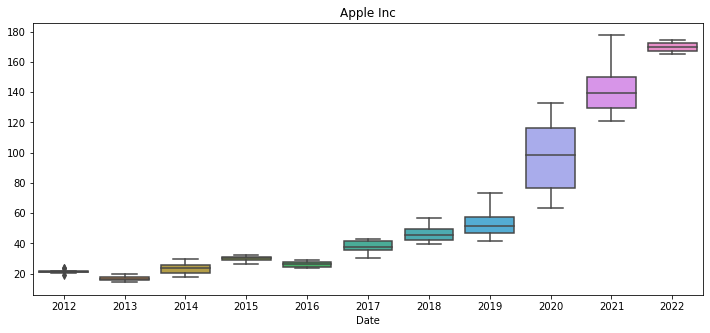

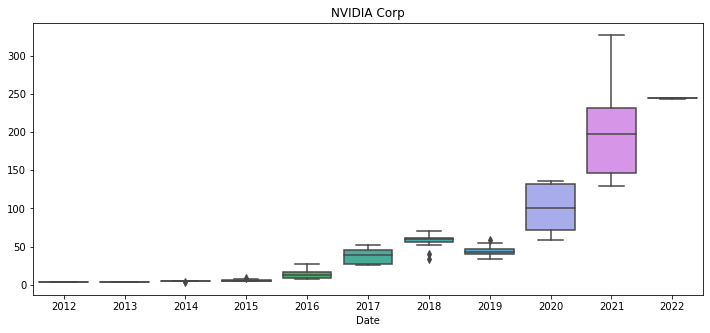

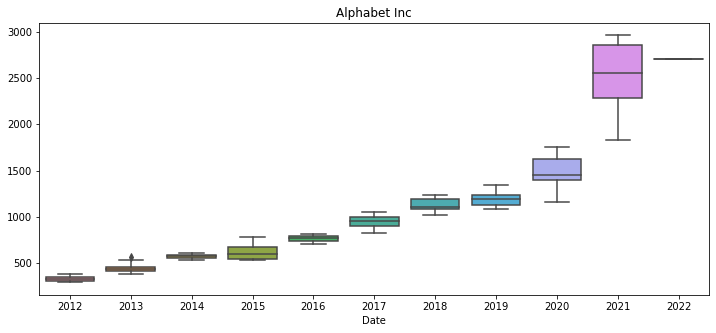

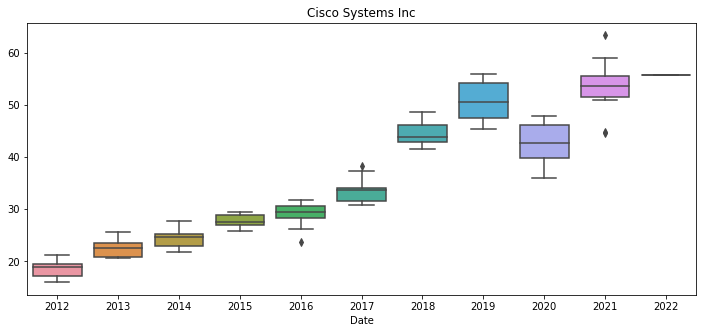

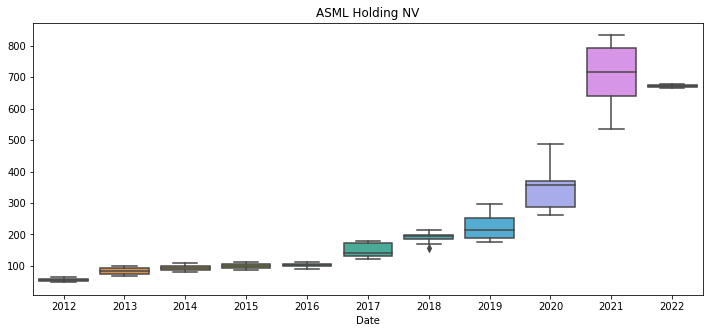

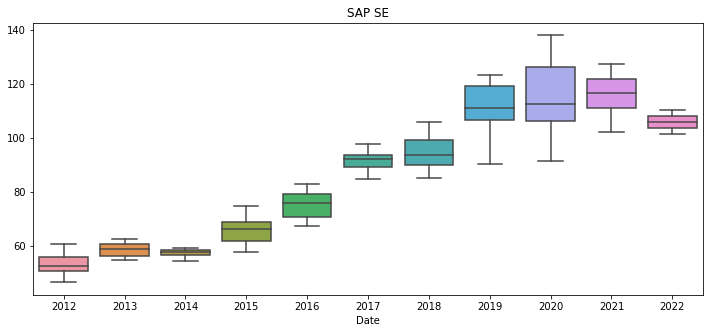

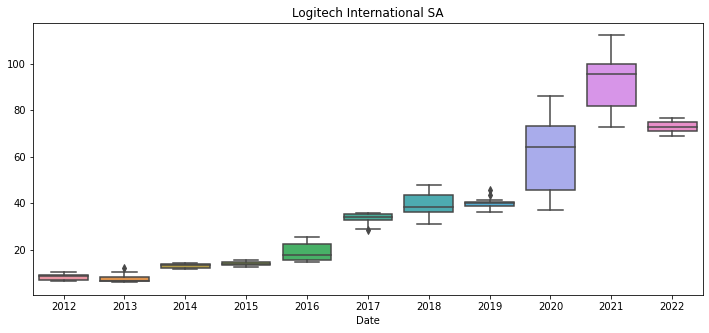

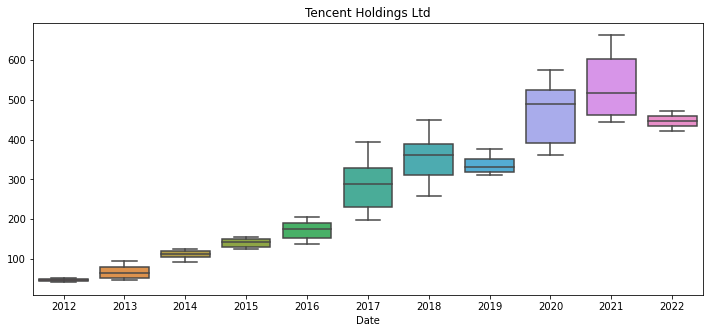

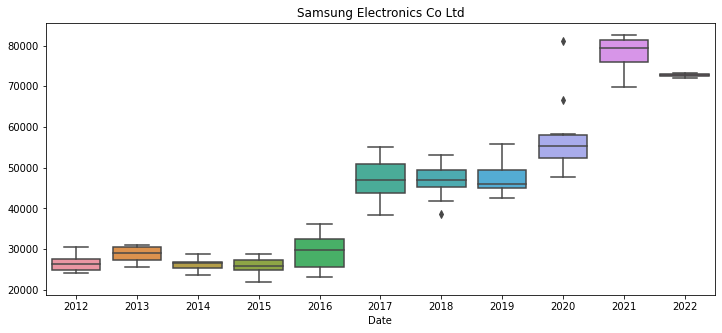

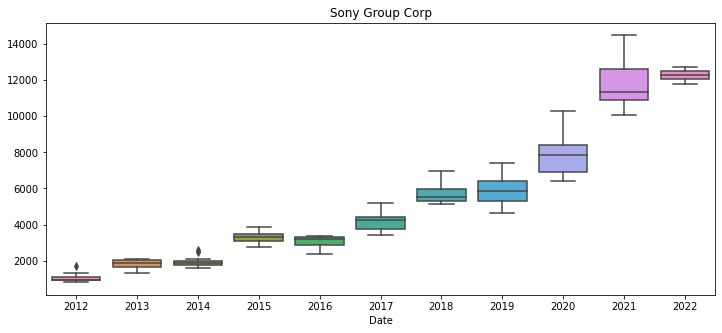

In [20]:
import pandas as pd
import numpy as np
import seaborn
import matplotlib.pyplot as plt

for i in range(0,len(assetdata.columns)):
    fig, ax = plt.subplots(figsize=(12,5))
    seaborn.boxplot(x=assetdata.iloc[:,i].index.year, y= assetdata.iloc[:,i].values, data=assetdata, ax=ax)
    ax.set_title(assetdata.columns[i])
    plt.savefig('Plots/Boxplot '+assetdata.columns[i]+' (original).jpg')
    

## 3.4 Deskriptive Statistik (Orginal)

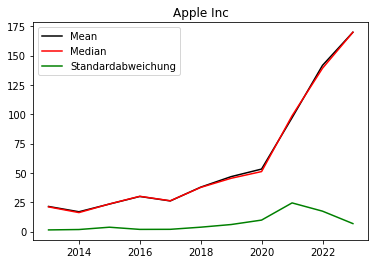

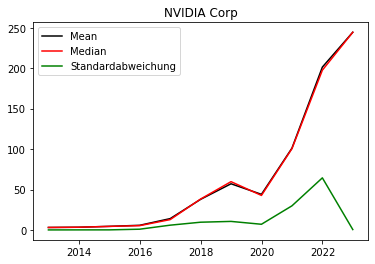

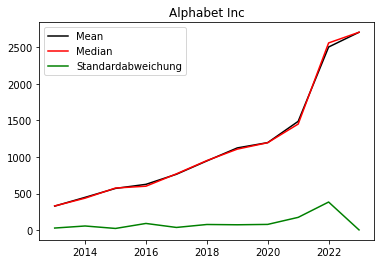

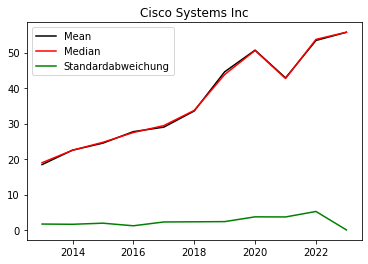

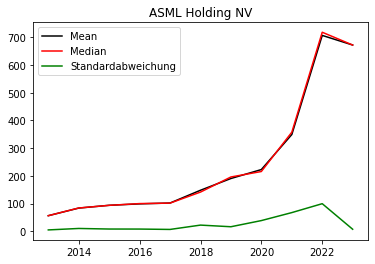

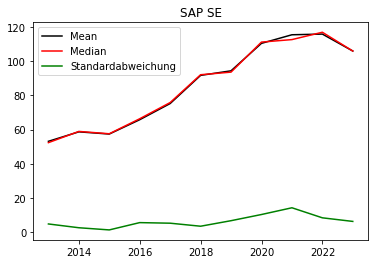

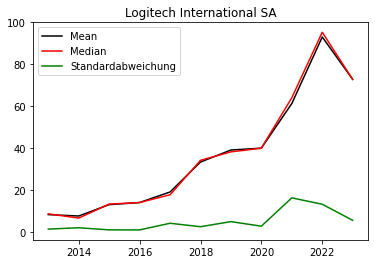

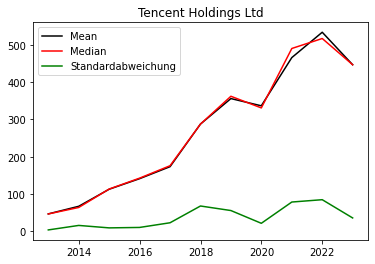

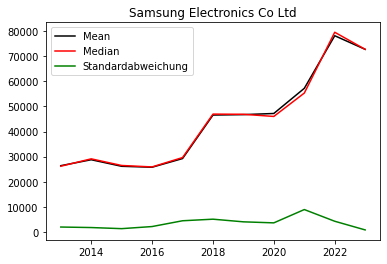

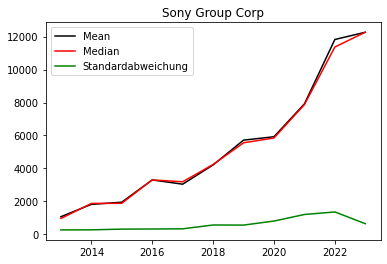

In [21]:
visual_describe(assetdata,1)

## 3.5 Stationarität (Orginal)

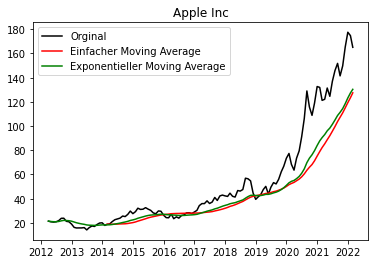

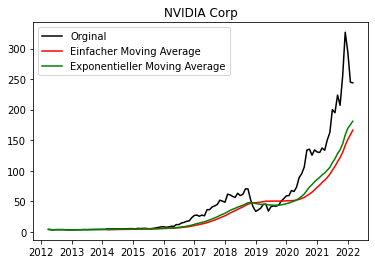

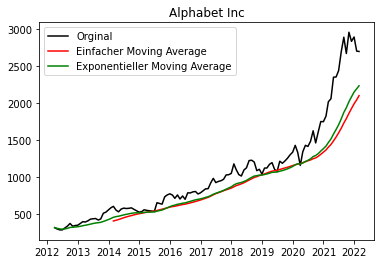

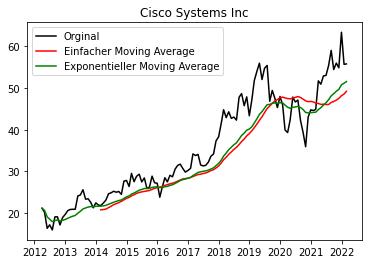

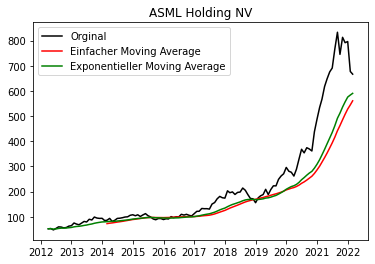

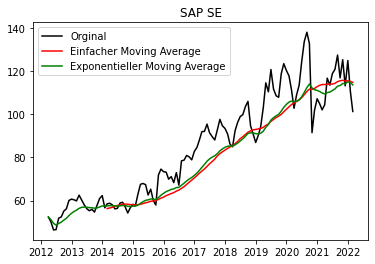

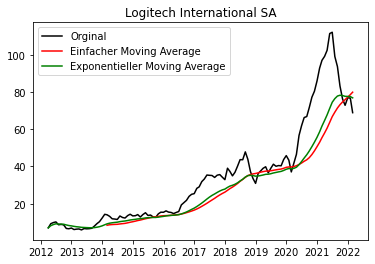

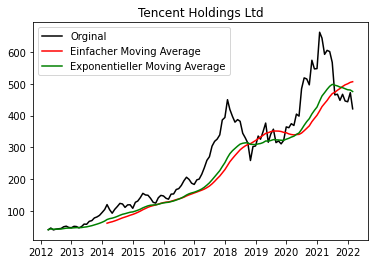

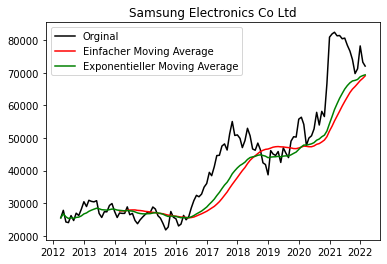

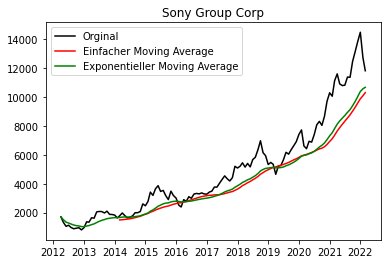

In [22]:
#Optisch
visual_stationarity(assetdata, 24,1)

In [23]:
#Mathematisch
dickey_fuller(assetdata)

Der p-Value von Apple Inc ist 0.999088. Somit ist die Zeitreihe nicht stationär.
Der p-Value von NVIDIA Corp ist 1.000000. Somit ist die Zeitreihe nicht stationär.
Der p-Value von Alphabet Inc ist 0.996343. Somit ist die Zeitreihe nicht stationär.
Der p-Value von Cisco Systems Inc ist 0.859129. Somit ist die Zeitreihe nicht stationär.
Der p-Value von ASML Holding NV ist 0.997717. Somit ist die Zeitreihe nicht stationär.
Der p-Value von SAP SE ist 0.802337. Somit ist die Zeitreihe nicht stationär.
Der p-Value von Logitech International SA ist 0.745658. Somit ist die Zeitreihe nicht stationär.
Der p-Value von Tencent Holdings Ltd ist 0.728986. Somit ist die Zeitreihe nicht stationär.
Der p-Value von Samsung Electronics Co Ltd ist 0.916991. Somit ist die Zeitreihe nicht stationär.
Der p-Value von Sony Group Corp ist 0.997565. Somit ist die Zeitreihe nicht stationär.

Somit ist der gesamte Datensatz nicht Stationär.


## 3.6 Normalverteilung (Orginal)

/Users/eldarhasani/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



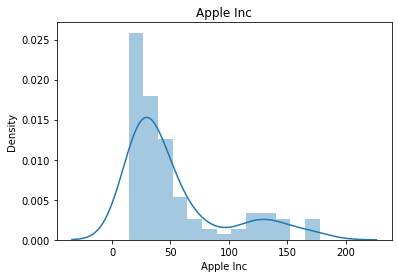

/Users/eldarhasani/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



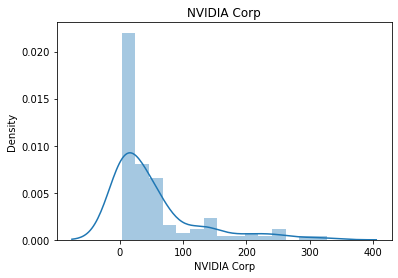

/Users/eldarhasani/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



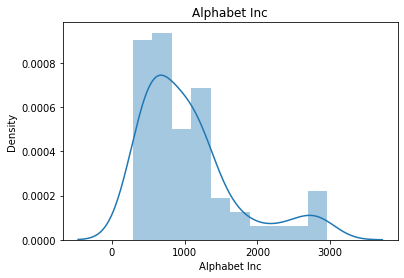

/Users/eldarhasani/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



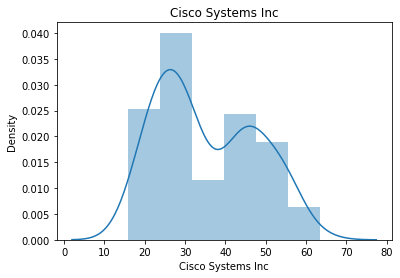

/Users/eldarhasani/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



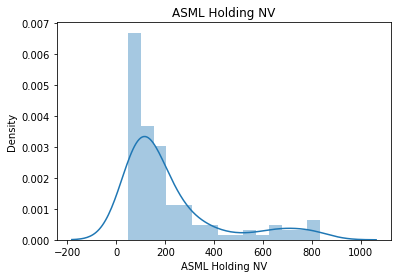

/Users/eldarhasani/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



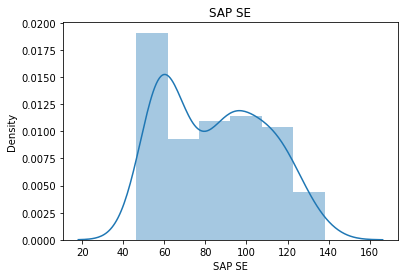

/Users/eldarhasani/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



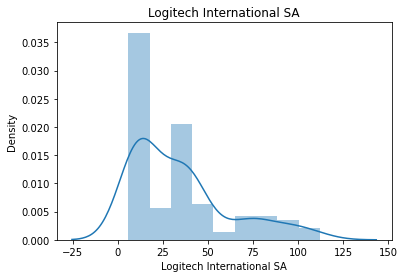

/Users/eldarhasani/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



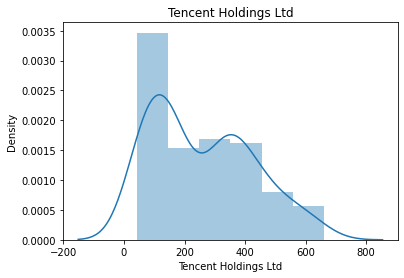

/Users/eldarhasani/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



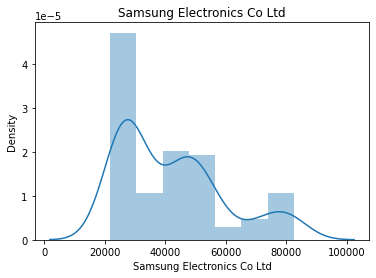

/Users/eldarhasani/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



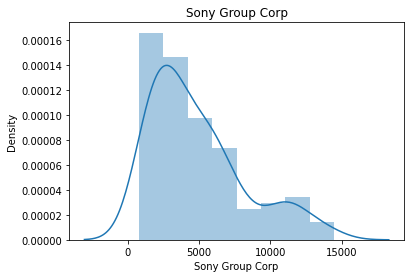

In [24]:
#Optisch
import seaborn as sns
import matplotlib.pylab as plt

for i in range(0,len(assetdata.columns)):
    y = assetdata.iloc[: , i]    
    sns.distplot(y)
    plt.title(y.name)
    plt.savefig('Plots/Normalverteilung '+y.name+' (original).jpg')
    plt.show()

In [25]:
#Mathematisch (Jarque Bera)
jarque_bera(assetdata)

Der p-Value von Apple Inc ist 0.000000. Somit ist die Zeitreihe nicht normalverteilt.
Der p-Value von NVIDIA Corp ist 0.000000. Somit ist die Zeitreihe nicht normalverteilt.
Der p-Value von Alphabet Inc ist 0.000000. Somit ist die Zeitreihe nicht normalverteilt.
Der p-Value von Cisco Systems Inc ist 0.013008. Somit ist die Zeitreihe nicht normalverteilt.
Der p-Value von ASML Holding NV ist 0.000000. Somit ist die Zeitreihe nicht normalverteilt.
Der p-Value von SAP SE ist 0.016080. Somit ist die Zeitreihe nicht normalverteilt.
Der p-Value von Logitech International SA ist 0.000001. Somit ist die Zeitreihe nicht normalverteilt.
Der p-Value von Tencent Holdings Ltd ist 0.017451. Somit ist die Zeitreihe nicht normalverteilt.
Der p-Value von Samsung Electronics Co Ltd ist 0.000354. Somit ist die Zeitreihe nicht normalverteilt.
Der p-Value von Sony Group Corp ist 0.000015. Somit ist die Zeitreihe nicht normalverteilt.

Somit ist der gesamte Datensatz nicht Normalverteilt.


In [26]:
#Mathematisch (Shapiro Wilk)
shapiro_wilk(assetdata)

Der p-Value von Apple Inc ist 0.000000. Somit ist die Zeitreihe nicht normalverteilt.
Der p-Value von NVIDIA Corp ist 0.000000. Somit ist die Zeitreihe nicht normalverteilt.
Der p-Value von Alphabet Inc ist 0.000000. Somit ist die Zeitreihe nicht normalverteilt.
Der p-Value von Cisco Systems Inc ist 0.000034. Somit ist die Zeitreihe nicht normalverteilt.
Der p-Value von ASML Holding NV ist 0.000000. Somit ist die Zeitreihe nicht normalverteilt.
Der p-Value von SAP SE ist 0.000022. Somit ist die Zeitreihe nicht normalverteilt.
Der p-Value von Logitech International SA ist 0.000000. Somit ist die Zeitreihe nicht normalverteilt.
Der p-Value von Tencent Holdings Ltd ist 0.000010. Somit ist die Zeitreihe nicht normalverteilt.
Der p-Value von Samsung Electronics Co Ltd ist 0.000000. Somit ist die Zeitreihe nicht normalverteilt.
Der p-Value von Sony Group Corp ist 0.000000. Somit ist die Zeitreihe nicht normalverteilt.

Somit ist der gesamte Datensatz nicht Normalverteilt.


## 3.7 Kompisition (Orginal)

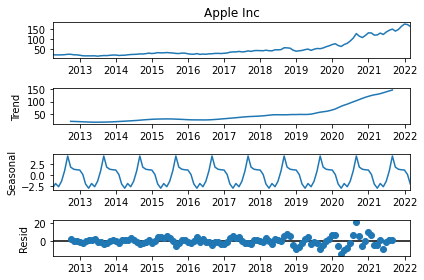

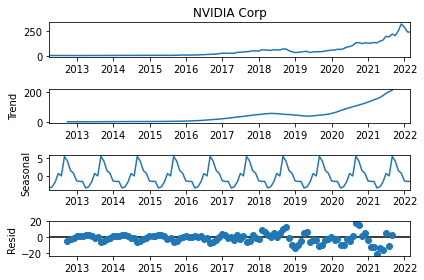

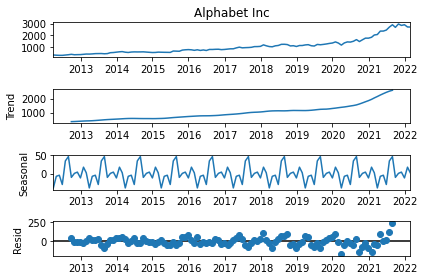

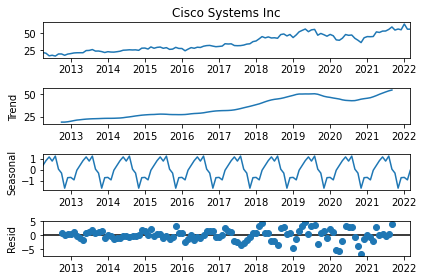

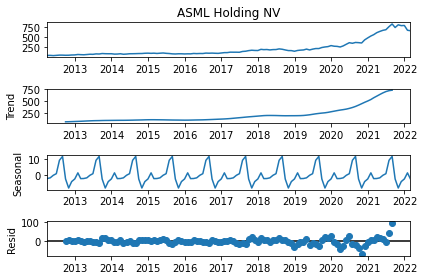

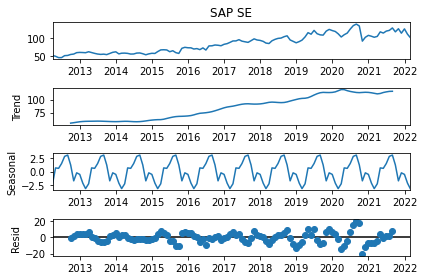

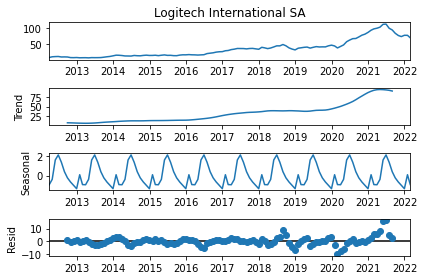

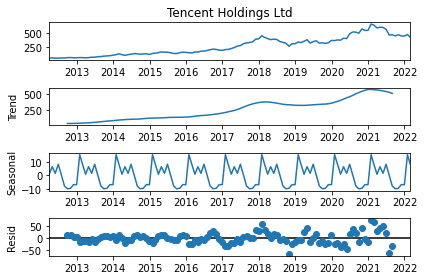

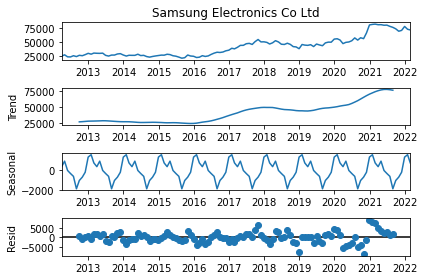

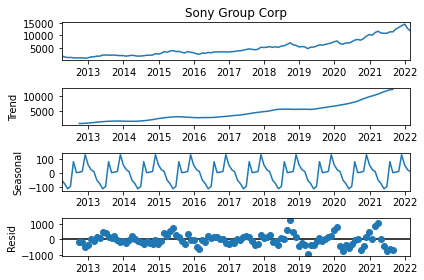

In [27]:
from statsmodels.tsa.seasonal import seasonal_decompose

for i in range(0,len(assetdata.columns)):
    decompose = seasonal_decompose(assetdata.iloc[:,i],model='additive', period=12)
    decompose.plot()
    plt.savefig('Plots/Komposition '+assetdata.columns[i]+' (original).jpg')
    plt.show()

## 3.8 Log-Returns machen

In [28]:
import numpy as np
assetdata_returns = (np.log(assetdata) - np.log(assetdata.shift(1))).dropna()

## 3.9 Deskriptive Statistik (Returns)

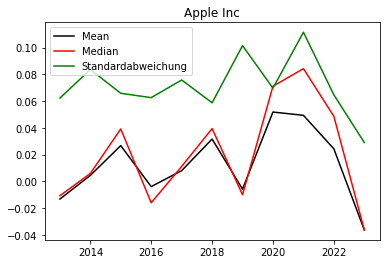

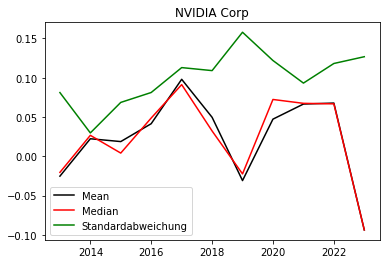

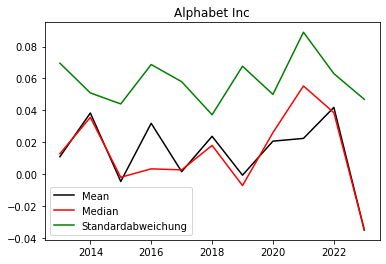

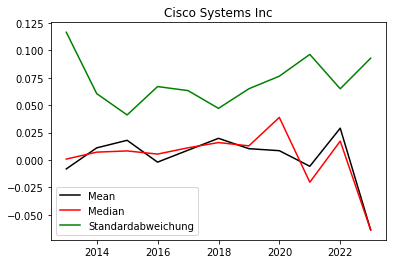

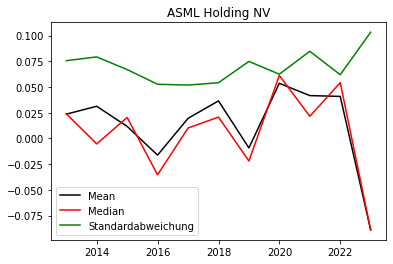

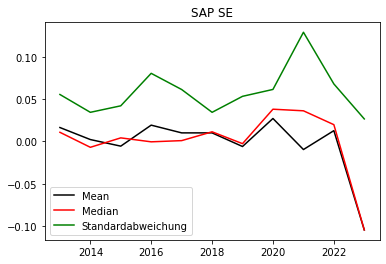

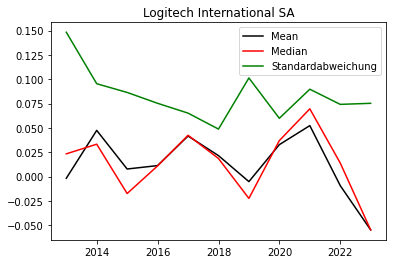

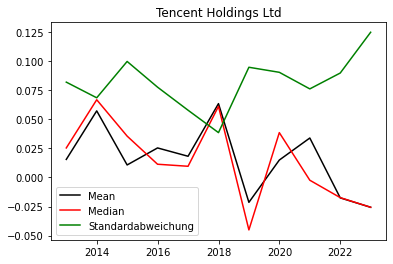

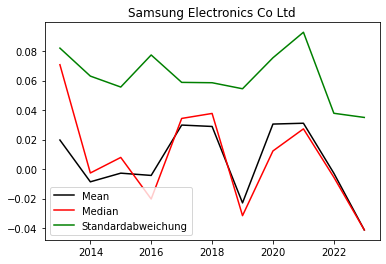

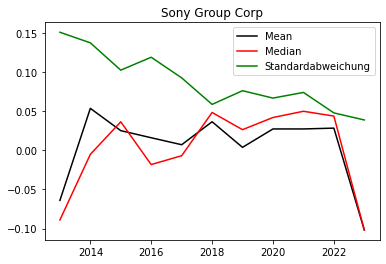

In [29]:
visual_describe(assetdata_returns,2)

## 3.10 Stationarität (Returns)

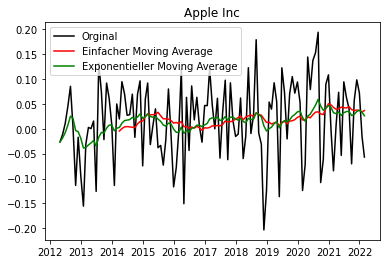

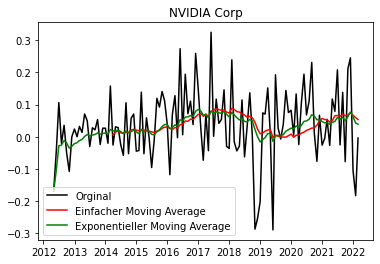

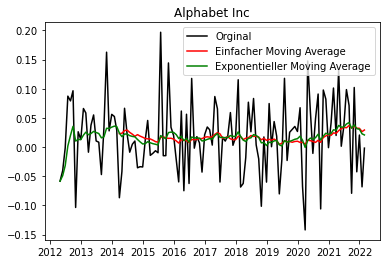

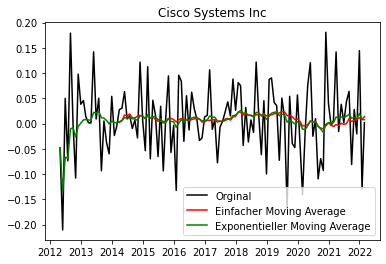

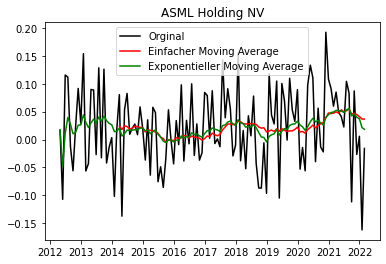

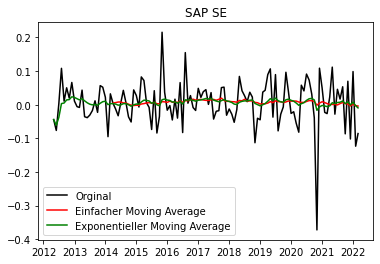

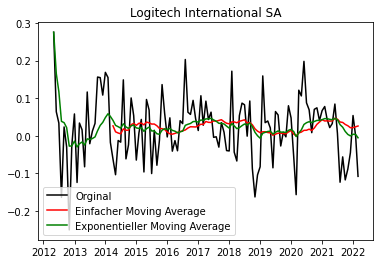

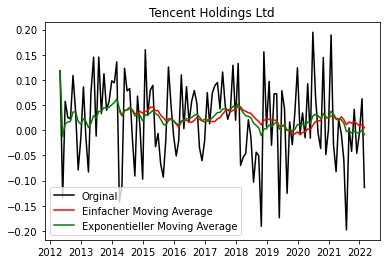

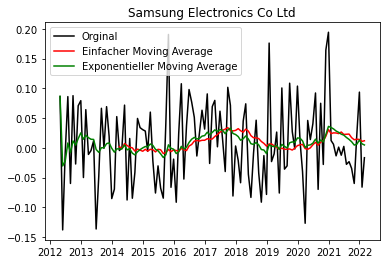

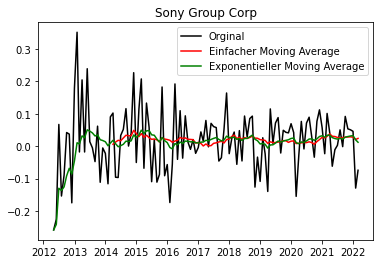

In [30]:
#Optisch
visual_stationarity(assetdata_returns, 24,2)

In [31]:
#Mathematisch
dickey_fuller(assetdata_returns)

Der gesamte Datensatz ist Stationär.


## 3.11 Normalverteilung (Returns)

/Users/eldarhasani/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



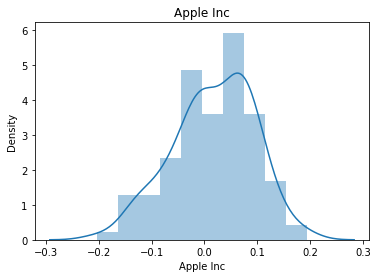

/Users/eldarhasani/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



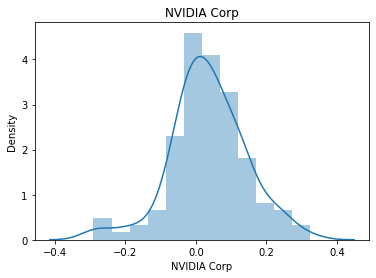

/Users/eldarhasani/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



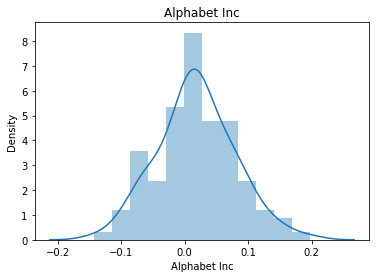

/Users/eldarhasani/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



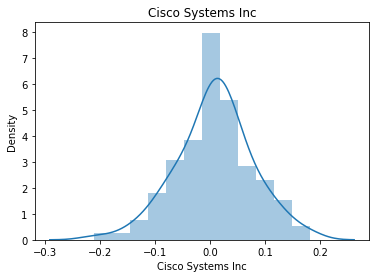

/Users/eldarhasani/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



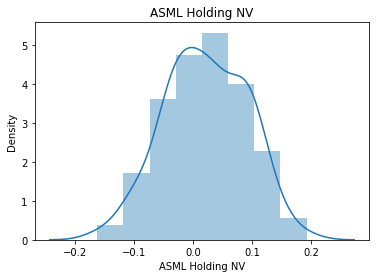

/Users/eldarhasani/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



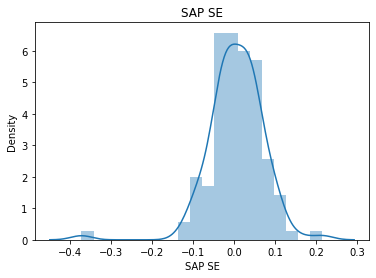

/Users/eldarhasani/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



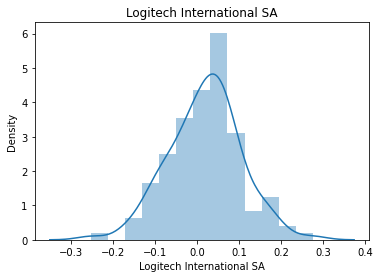

/Users/eldarhasani/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



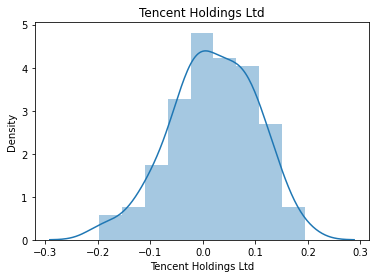

/Users/eldarhasani/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



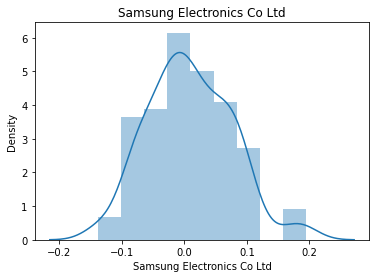

/Users/eldarhasani/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



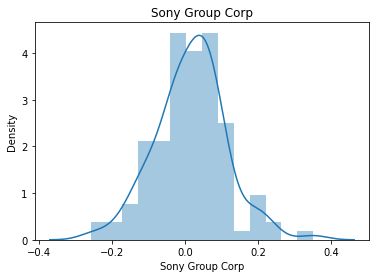

In [32]:
#Optisch

import seaborn as sns

import matplotlib.pylab as plt
for i in range(0,len(assetdata_returns.columns)):
    y = assetdata_returns.iloc[: , i]    
    sns.distplot(y)
    plt.title(y.name)
    plt.savefig('Plots/Normalverteilung '+y.name+' (returns).jpg')
    plt.show()

In [33]:
#Mathematsch (Shapiro Wilk)
shapiro_wilk(assetdata_returns)

Der p-Value von NVIDIA Corp ist 0.023153. Somit ist die Zeitreihe nicht normalverteilt.
Der p-Value von SAP SE ist 0.000001. Somit ist die Zeitreihe nicht normalverteilt.

Der Rest ist Normalverteilt.


## 3.12 Boxplot (Returns)

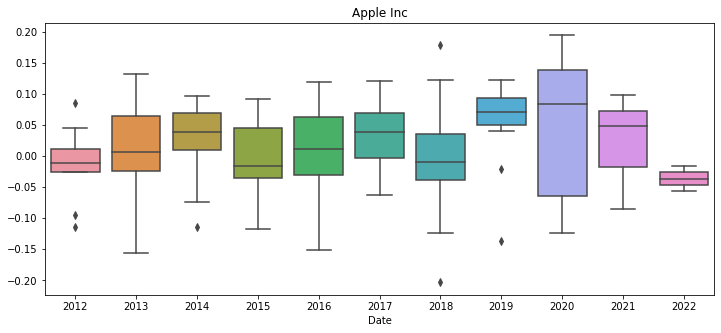

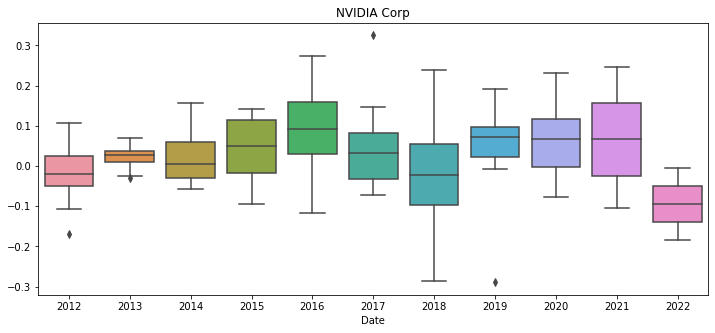

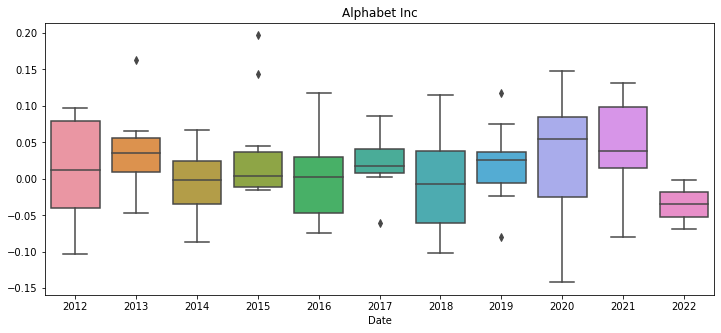

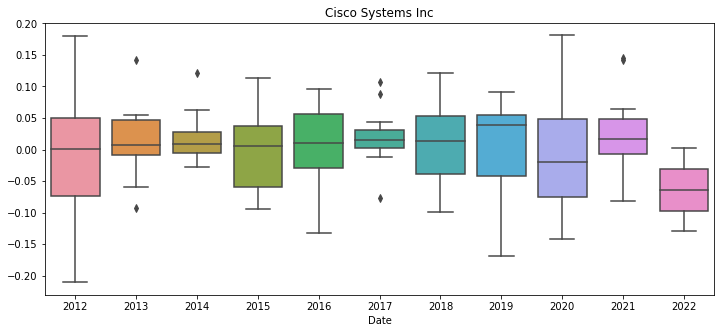

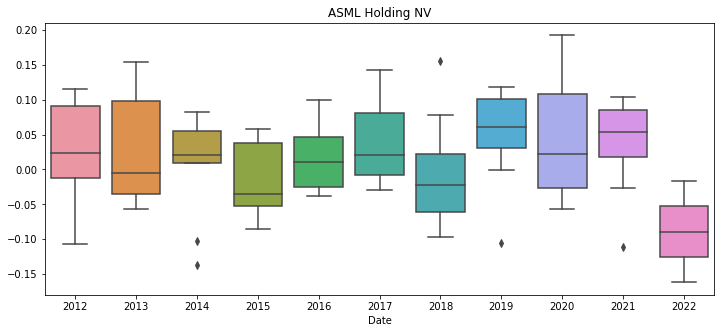

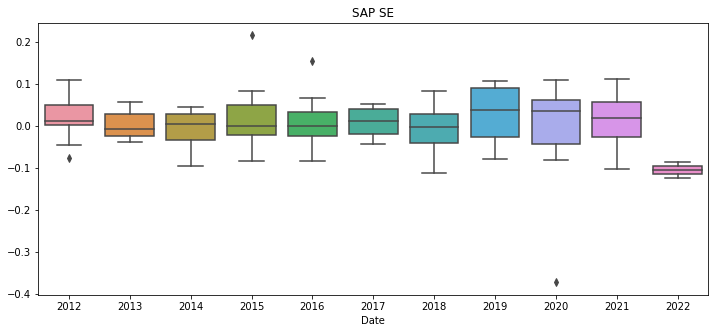

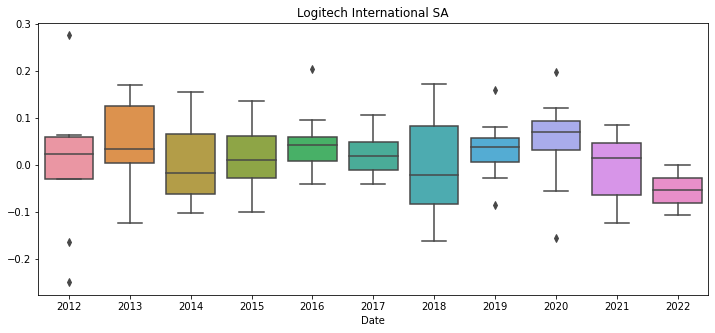

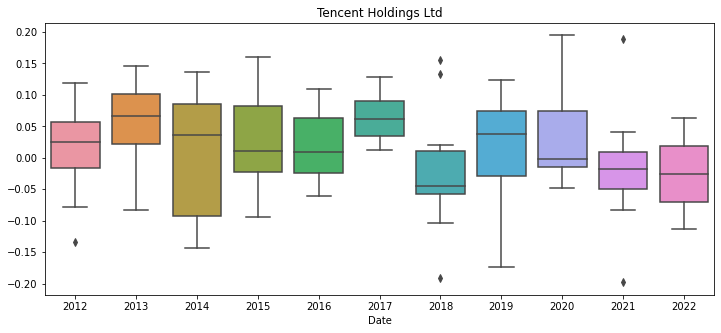

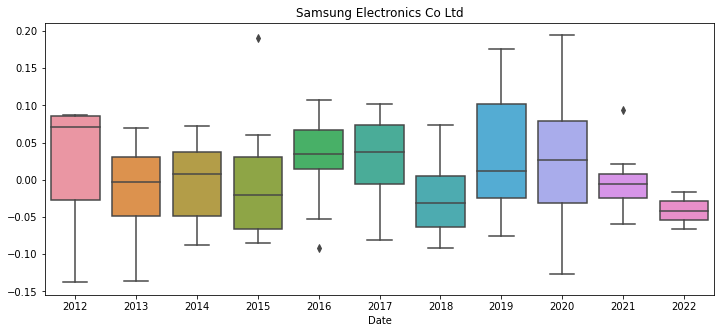

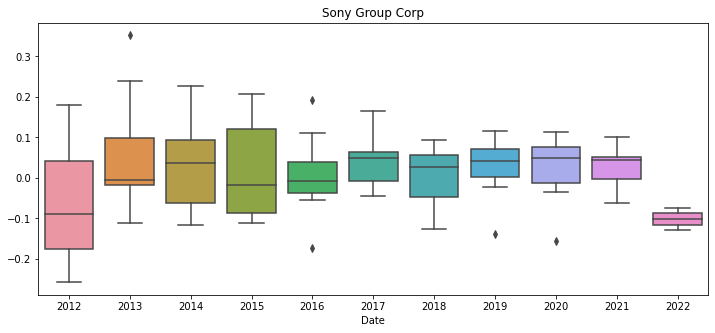

In [34]:
import pandas as pd
import numpy as np
import seaborn
import matplotlib.pyplot as plt

for i in range(0,len(assetdata_returns.columns)):
    fig, ax = plt.subplots(figsize=(12,5))
    seaborn.boxplot(x=assetdata_returns.iloc[:,i].index.year, y= assetdata_returns.iloc[:,i].values, data=assetdata, ax=ax)
    ax.set_title(assetdata_returns.columns[i])
    plt.savefig('Plots/Boxplot '+assetdata.columns[i]+' (returns).jpg')

## 3.13 Kompositionen (Returns)

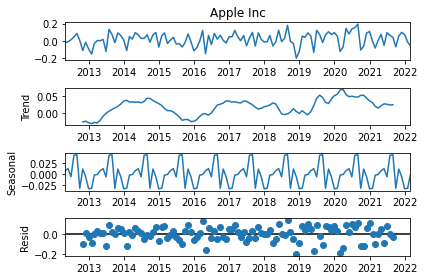

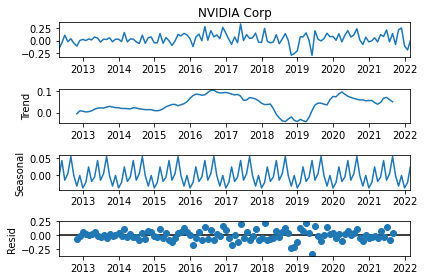

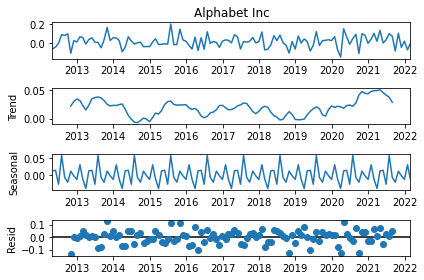

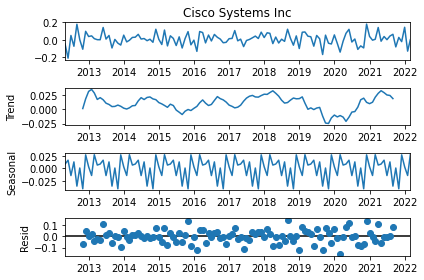

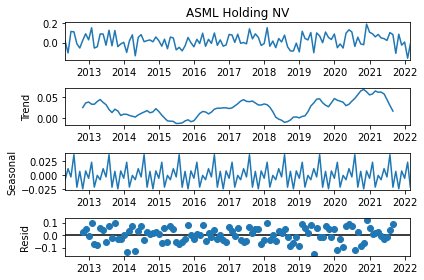

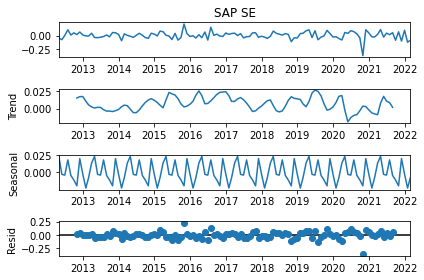

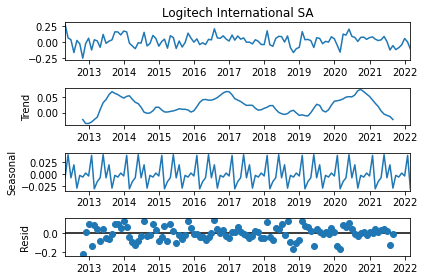

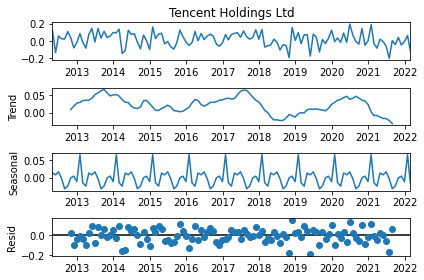

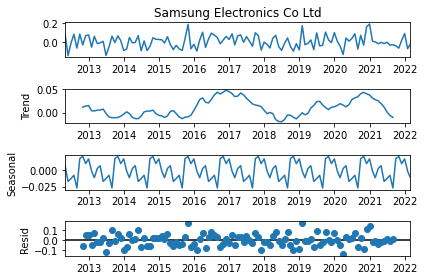

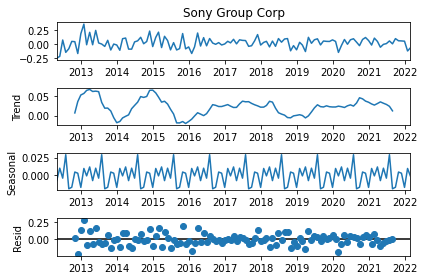

In [35]:
from statsmodels.tsa.seasonal import seasonal_decompose

for i in range(0,len(assetdata_returns.columns)):
    decompose = seasonal_decompose(assetdata_returns.iloc[:,i],model='additive', period=12)
    decompose.plot()
    plt.savefig('Plots/Komposition '+assetdata.columns[i]+' (returns).jpg')
    plt.show()

# 4. Makrodaten analysieren

## 4.1 NA's prüfen

In [36]:
na_ckeck(macrodata)

USGDPF=ECI hat 80 NA's 
NLGDP=ECI hat 80 NA's 
NLDPROINDMISMEI hat 2 NA's 
XTIMVA01NLM667S hat 1 NA's 
XTEXVA01NLM664S hat 1 NA's 
EUGDP=ECI hat 80 NA's 
EA19PRINTO01GPSAM hat 1 NA's 
EA19SLRTTO02IXOBSAM hat 1 NA's 
XTIMVA01EZM667S hat 1 NA's 
XTEXVA01EZM667S hat 1 NA's 
CHGDP=ECI hat 80 NA's 
CHEPROINDQISMEI hat 81 NA's 
DEGDP=ECI hat 80 NA's 
DEUPROINDMISMEI hat 1 NA's 
CNRSL=ECI hat 10 NA's 
CNIO=ECI hat 10 NA's 
CNGDPA=ECI hat 80 NA's 
CHNPRINTO01IXPYM hat 12 NA's 
JPGD1=ECI hat 80 NA's 
KRIMP=ECI hat 22 NA's 
KRGDQA=ECI hat 80 NA's 

Der Rest hat keine NA's.


In [37]:
macrodata_us = macrodata_us.fillna(method='ffill')
macrodata_nl = macrodata_nl.fillna(method='ffill')
macrodata_eu = macrodata_eu.fillna(method='ffill')
macrodata_ch = macrodata_ch.fillna(method='ffill')
macrodata_de = macrodata_de.fillna(method='ffill')
macrodata_cn = macrodata_cn.fillna(method='ffill')
macrodata_jp = macrodata_jp.fillna(method='ffill')
macrodata_sk = macrodata_sk.fillna(method='ffill')
macrodata = macrodata_us.join(macrodata_nl, how='left').join(macrodata_eu, how='left').join(macrodata_ch, how='left').join(macrodata_de, how='left').join(macrodata_cn, how='left').join(macrodata_jp, how='left').join(macrodata_sk, how='left')    

In [38]:
na_ckeck(macrodata)
#KRIMP hat nicht geklappt weil es vom Start het NA's hat daher wird die 'backfill' Methode verwendet

KRIMP=ECI hat 22 NA's 

Der Rest hat keine NA's.


In [39]:
macrodata['KRIMP=ECI'] = macrodata['KRIMP=ECI'].fillna(method='backfill')

In [40]:
na_ckeck(macrodata)

Der gesamte Datensatz hat keine NA's.


## 4.2 Multikollinearität

In [41]:
corr_us = macrodata_us.corr()
corr_nl = macrodata_nl.corr()
corr_eu = macrodata_eu.corr()
corr_ch = macrodata_ch.corr()
corr_de = macrodata_de.corr()
corr_cn = macrodata_cn.corr()
corr_jp = macrodata_jp.corr()
corr_sk = macrodata_sk.corr()

/var/folders/r4/xbxvc60d62dfrl7dq7k_kc_40000gn/T/ipykernel_7116/363408613.py:6: FutureWarning:

In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.



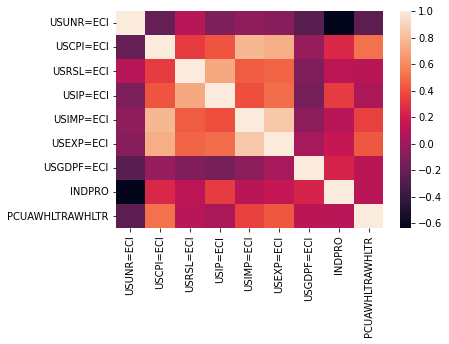

In [42]:
import seaborn as sns
sns_plot = sns.heatmap(corr_us, xticklabels=corr_us.columns.values,yticklabels=corr_us.columns.values)
fig = sns_plot.get_figure()
fig.savefig('Plots/Korrelation Makrodaten US.jpg')

macrodata_us = macrodata_us.drop('INDPRO', 1)

/var/folders/r4/xbxvc60d62dfrl7dq7k_kc_40000gn/T/ipykernel_7116/133097356.py:5: FutureWarning:

In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.



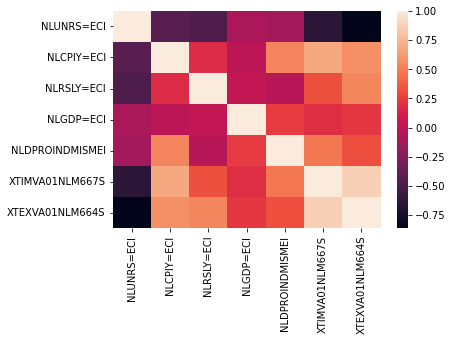

In [43]:
sns_plot = sns.heatmap(corr_nl, xticklabels=corr_nl.columns.values,yticklabels=corr_nl.columns.values)
fig = sns_plot.get_figure()
fig.savefig('Plots/Korrelation Makrodaten NL.jpg')

macrodata_nl = macrodata_nl.drop('XTEXVA01NLM664S', 1)

/var/folders/r4/xbxvc60d62dfrl7dq7k_kc_40000gn/T/ipykernel_7116/2564550514.py:5: FutureWarning:

In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.



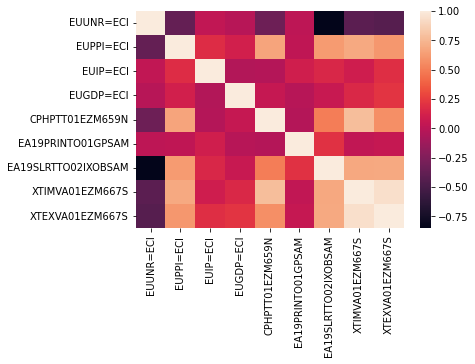

In [44]:
sns_plot = sns.heatmap(corr_eu, xticklabels=corr_eu.columns.values,yticklabels=corr_eu.columns.values)
fig = sns_plot.get_figure()
fig.savefig('Plots/Korrelation Makrodaten EU.jpg')

macrodata_eu = macrodata_eu.drop('EA19SLRTTO02IXOBSAM', 1)

/var/folders/r4/xbxvc60d62dfrl7dq7k_kc_40000gn/T/ipykernel_7116/3772966104.py:5: FutureWarning:

In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.



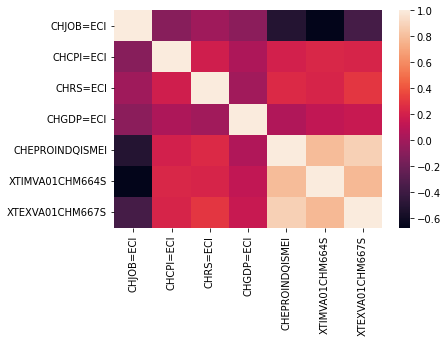

In [45]:
sns_plot = sns.heatmap(corr_ch, xticklabels=corr_ch.columns.values,yticklabels=corr_ch.columns.values)
fig = sns_plot.get_figure()
fig.savefig('Plots/Korrelation Makrodaten CH.jpg')

macrodata_ch = macrodata_ch.drop('XTIMVA01CHM664S', 1)

/var/folders/r4/xbxvc60d62dfrl7dq7k_kc_40000gn/T/ipykernel_7116/3564859122.py:5: FutureWarning:

In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.



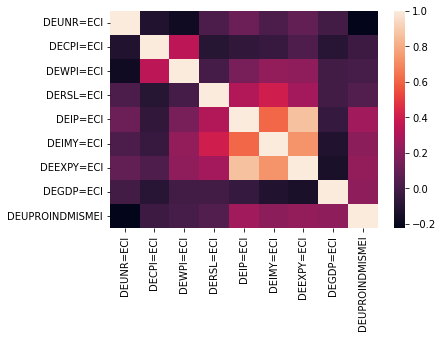

In [46]:
sns_plot = sns.heatmap(corr_de, xticklabels=corr_de.columns.values,yticklabels=corr_de.columns.values)
fig = sns_plot.get_figure()
fig.savefig('Plots/Korrelation Makrodaten DE.jpg')

macrodata_de = macrodata_de.drop(['DEUPROINDMISMEI','DEWPI=ECI','DEWPI=ECI'], 1)

/var/folders/r4/xbxvc60d62dfrl7dq7k_kc_40000gn/T/ipykernel_7116/2330061290.py:5: FutureWarning:

In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.



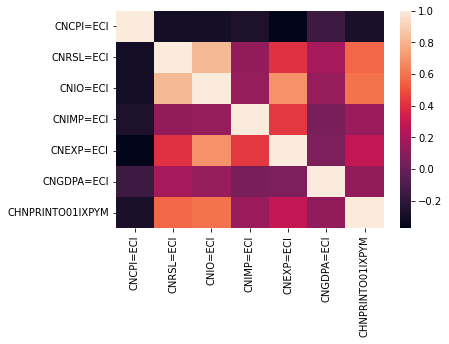

In [47]:
sns_plot = sns.heatmap(corr_cn, xticklabels=corr_cn.columns.values,yticklabels=corr_cn.columns.values)
fig = sns_plot.get_figure()
fig.savefig('Plots/Korrelation Makrodaten CN.jpg')

macrodata_cn = macrodata_cn.drop(['CNIO=ECI','CNEXP=ECI','CHNPRINTO01IXPYM'], 1)

/var/folders/r4/xbxvc60d62dfrl7dq7k_kc_40000gn/T/ipykernel_7116/704137045.py:5: FutureWarning:

In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.



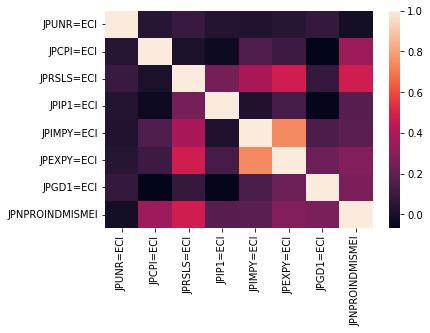

In [48]:
sns_plot = sns.heatmap(corr_jp, xticklabels=corr_jp.columns.values,yticklabels=corr_jp.columns.values)
fig = sns_plot.get_figure()
fig.savefig('Plots/Korrelation Makrodaten JP.jpg')

macrodata_jp = macrodata_jp.drop(['JPGD1=ECI','JPIP1=ECI','JPNPROINDMISMEI'], 1)

/var/folders/r4/xbxvc60d62dfrl7dq7k_kc_40000gn/T/ipykernel_7116/1894684960.py:5: FutureWarning:

In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.



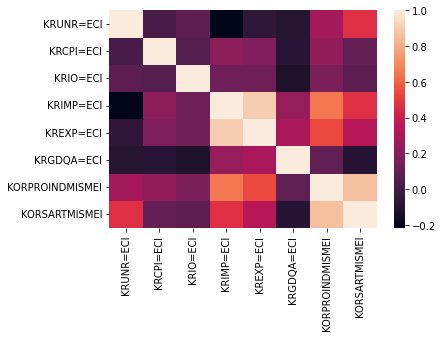

In [49]:
sns_plot = sns.heatmap(corr_sk, xticklabels=corr_sk.columns.values,yticklabels=corr_sk.columns.values)
fig = sns_plot.get_figure()
fig.savefig('Plots/Korrelation Makrodaten SK.jpg')

macrodata_sk = macrodata_sk.drop(['KRIMP=ECI','KORSARTMISMEI'], 1)

## 4.3 Boxplot

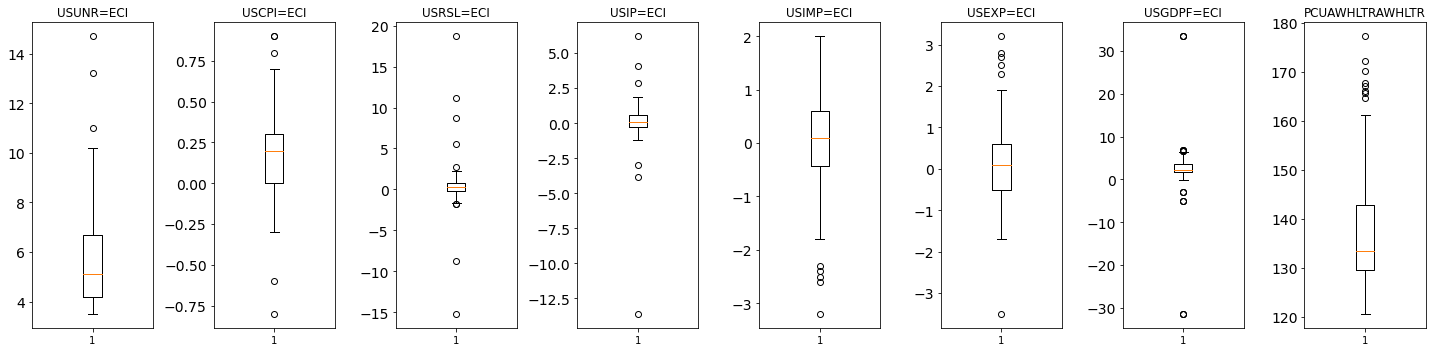

In [50]:
boxplot(macrodata_us.dropna())

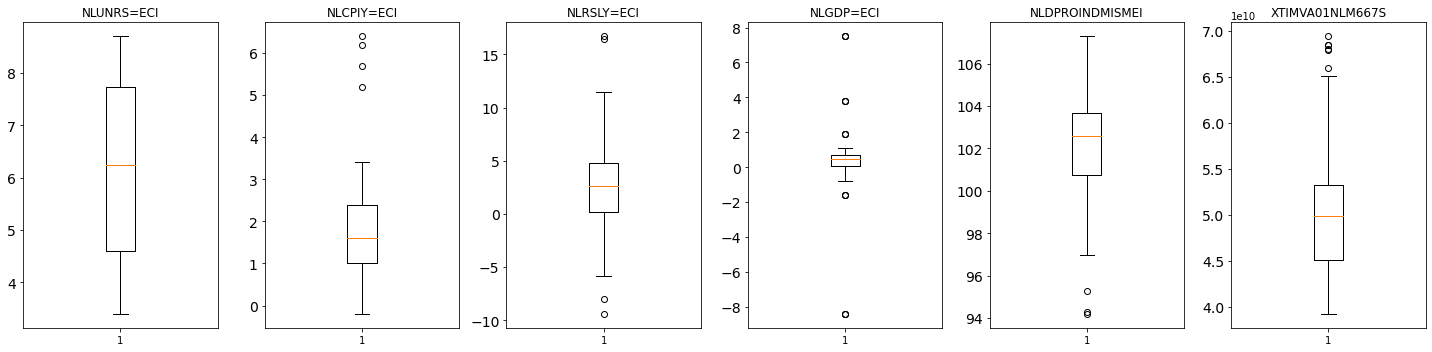

In [51]:
boxplot(macrodata_nl.dropna())

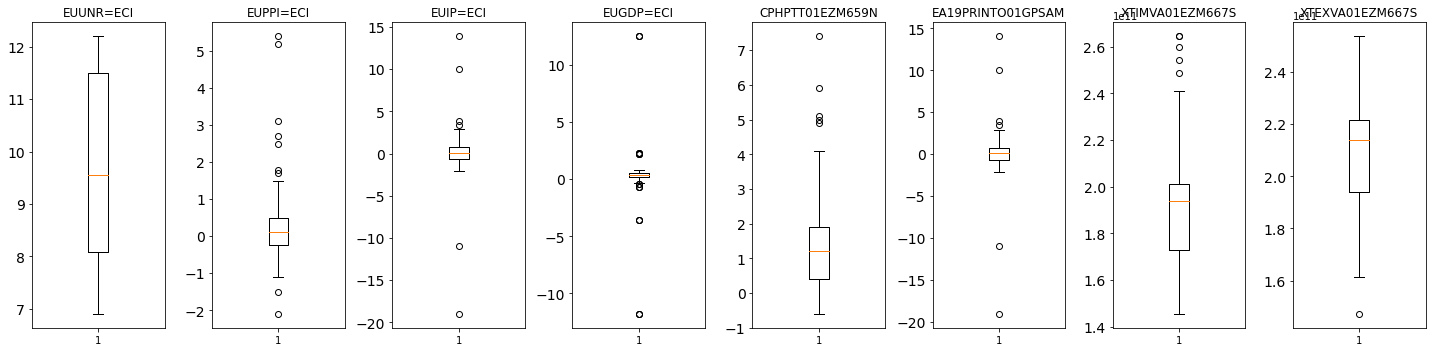

In [52]:
boxplot(macrodata_eu.dropna())

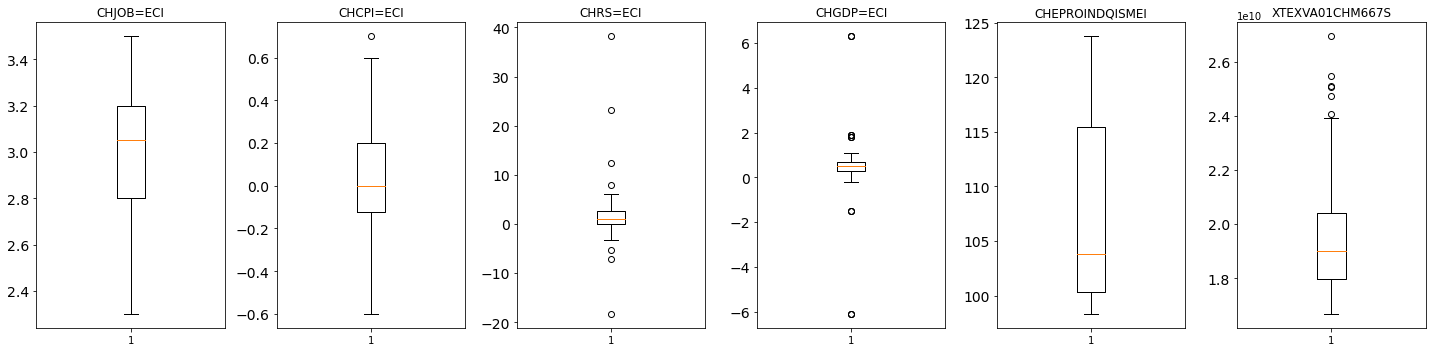

In [53]:
boxplot(macrodata_ch.dropna())

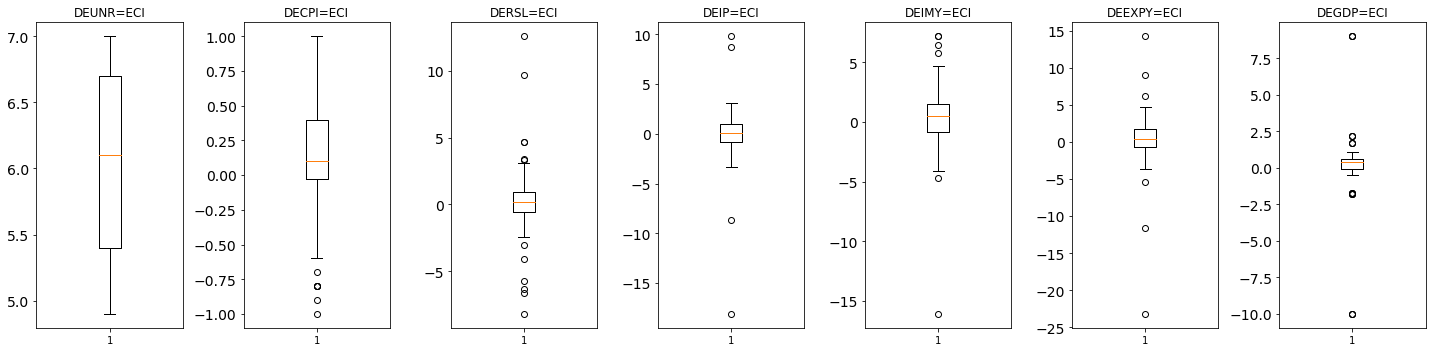

In [54]:
boxplot(macrodata_de.dropna())

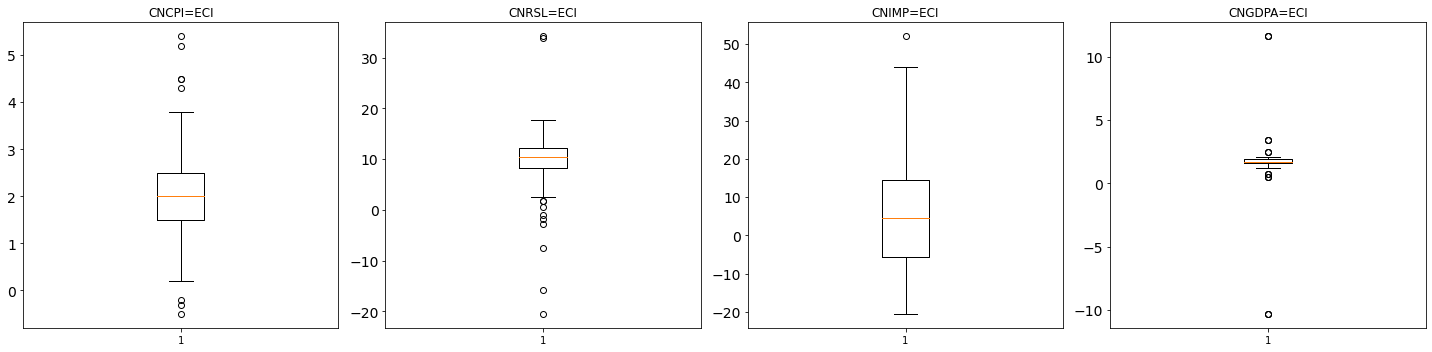

In [55]:
boxplot(macrodata_cn.dropna())

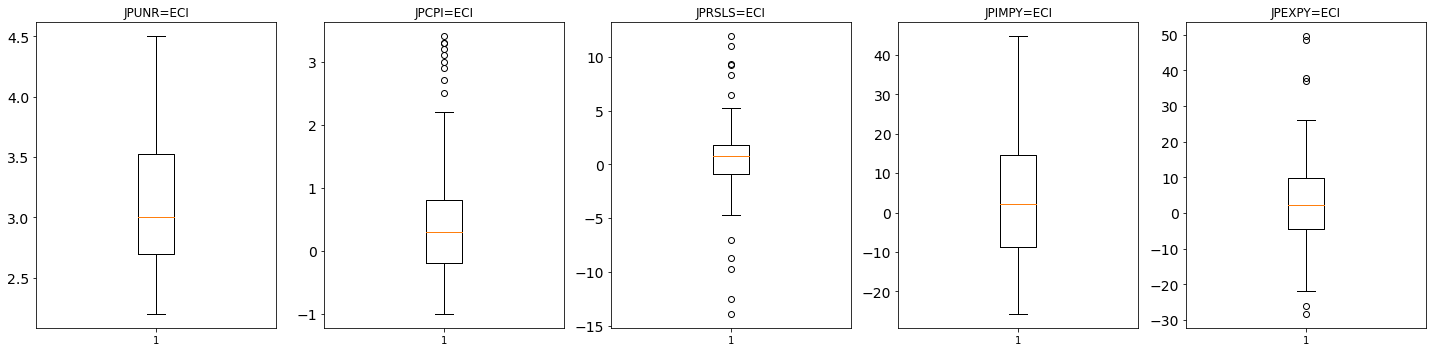

In [56]:
boxplot(macrodata_jp.dropna())

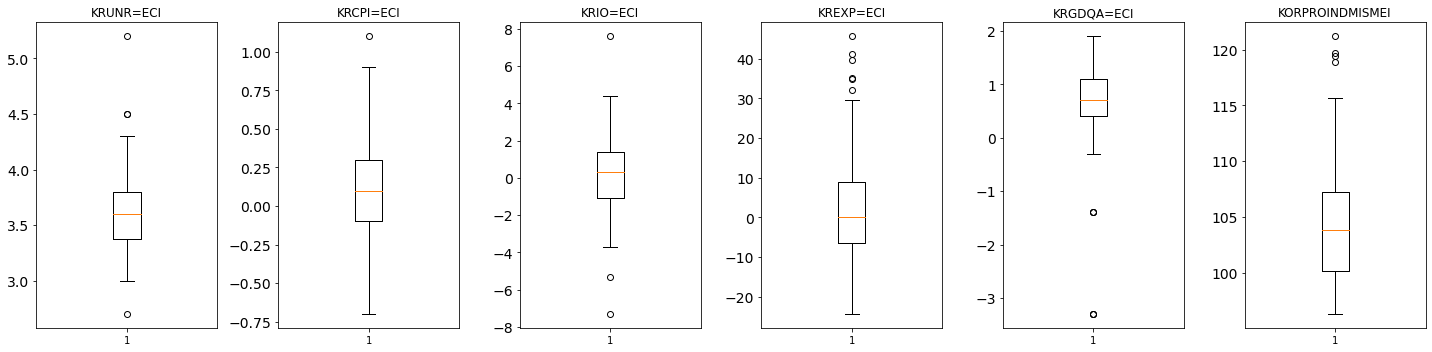

In [57]:
boxplot(macrodata_sk.dropna())

## 4.4 Deskriptive Statistik

In [58]:
macrodata = macrodata_us.join(macrodata_nl, how='left').join(macrodata_eu, how='left').join(macrodata_ch, how='left').join(macrodata_de, how='left').join(macrodata_cn, how='left').join(macrodata_jp, how='left').join(macrodata_sk, how='left')    
macrodata.describe()

,USUNR=ECI,USCPI=ECI,USRSL=ECI,USIP=ECI,USIMP=ECI,USEXP=ECI,USGDPF=ECI,PCUAWHLTRAWHLTR,NLUNRS=ECI,NLCPIY=ECI,...,JPCPI=ECI,JPRSLS=ECI,JPIMPY=ECI,JPEXPY=ECI,KRUNR=ECI,KRCPI=ECI,KRIO=ECI,KREXP=ECI,KRGDQA=ECI,KORPROINDMISMEI
count,120.000000,120.000000,120.000000,120.000000,120.000000,120.000000,120.00000,120.000000,120.000000,120.000000,...,120.000000,120.000000,120.000000,120.000000,120.000000,120.000000,120.00000,120.000000,120.000000,120.000000
mean,5.638333,0.185000,0.460000,0.070833,0.010000,0.125833,2.43000,137.045975,6.206667,1.719167,...,0.484167,0.587500,3.681667,3.440000,3.602500,0.119167,0.16000,2.652500,0.607500,104.595517
std,1.928477,0.263349,2.812649,1.609603,0.948542,0.938038,7.59213,11.854629,1.599356,1.153679,...,0.954423,3.557252,15.591212,12.501989,0.367929,0.330596,1.97707,13.334084,0.833658,5.421497
min,3.500000,-0.800000,-15.200000,-13.600000,-3.200000,-3.500000,-31.40000,120.600000,3.400000,-0.200000,...,-1.000000,-13.900000,-25.700000,-28.300000,2.700000,-0.700000,-7.30000,-24.300000,-3.300000,96.300000
25%,4.175000,0.000000,-0.200000,-0.300000,-0.425000,-0.500000,1.70000,129.575000,4.600000,1.000000,...,-0.200000,-0.900000,-8.700000,-4.600000,3.375000,-0.100000,-1.10000,-6.325000,0.400000,100.193250
50%,5.100000,0.200000,0.300000,0.100000,0.100000,0.100000,2.25000,133.450000,6.250000,1.600000,...,0.300000,0.750000,2.100000,2.400000,3.600000,0.100000,0.30000,0.100000,0.700000,103.850000
75%,6.700000,0.300000,0.800000,0.600000,0.600000,0.600000,3.60000,142.900000,7.725000,2.400000,...,0.800000,1.825000,14.700000,9.725000,3.800000,0.300000,1.40000,8.925000,1.100000,107.200000
max,14.700000,0.900000,18.700000,6.200000,2.000000,3.200000,33.40000,177.211000,8.700000,6.400000,...,3.400000,11.900000,44.700000,49.600000,5.200000,1.100000,7.60000,45.600000,1.900000,121.200000


## 4.5 Stationarität (Orginal)

In [59]:
dickey_fuller(macrodata)

Der p-Value von PCUAWHLTRAWHLTR ist 1.000000. Somit ist die Zeitreihe nicht stationär.
Der p-Value von NLUNRS=ECI ist 0.956763. Somit ist die Zeitreihe nicht stationär.
Der p-Value von NLCPIY=ECI ist 0.764685. Somit ist die Zeitreihe nicht stationär.
Der p-Value von NLRSLY=ECI ist 0.555164. Somit ist die Zeitreihe nicht stationär.
Der p-Value von NLGDP=ECI ist 0.110415. Somit ist die Zeitreihe nicht stationär.
Der p-Value von XTIMVA01NLM667S ist 0.972354. Somit ist die Zeitreihe nicht stationär.
Der p-Value von EUUNR=ECI ist 0.935090. Somit ist die Zeitreihe nicht stationär.
Der p-Value von EUPPI=ECI ist 0.983476. Somit ist die Zeitreihe nicht stationär.
Der p-Value von CPHPTT01EZM659N ist 0.960007. Somit ist die Zeitreihe nicht stationär.
Der p-Value von XTIMVA01EZM667S ist 0.929012. Somit ist die Zeitreihe nicht stationär.
Der p-Value von XTEXVA01EZM667S ist 0.341522. Somit ist die Zeitreihe nicht stationär.
Der p-Value von CHJOB=ECI ist 0.313477. Somit ist die Zeitreihe nicht statio

## 4.6 Normalverteilung (Orginal)

In [60]:
shapiro_wilk(macrodata)

Der p-Value von USUNR=ECI ist 0.000000. Somit ist die Zeitreihe nicht normalverteilt.
Der p-Value von USCPI=ECI ist 0.001118. Somit ist die Zeitreihe nicht normalverteilt.
Der p-Value von USRSL=ECI ist 0.000000. Somit ist die Zeitreihe nicht normalverteilt.
Der p-Value von USIP=ECI ist 0.000000. Somit ist die Zeitreihe nicht normalverteilt.
Der p-Value von USIMP=ECI ist 0.001373. Somit ist die Zeitreihe nicht normalverteilt.
Der p-Value von USEXP=ECI ist 0.000190. Somit ist die Zeitreihe nicht normalverteilt.
Der p-Value von USGDPF=ECI ist 0.000000. Somit ist die Zeitreihe nicht normalverteilt.
Der p-Value von PCUAWHLTRAWHLTR ist 0.000000. Somit ist die Zeitreihe nicht normalverteilt.
Der p-Value von NLUNRS=ECI ist 0.000002. Somit ist die Zeitreihe nicht normalverteilt.
Der p-Value von NLCPIY=ECI ist 0.000000. Somit ist die Zeitreihe nicht normalverteilt.
Der p-Value von NLRSLY=ECI ist 0.008016. Somit ist die Zeitreihe nicht normalverteilt.
Der p-Value von NLGDP=ECI ist 0.000000. Somit

## 4.7 Stationarität (Returns)

In [61]:
macrodata_returns = logtransform(macrodata)

In [62]:
dickey_fuller(macrodata_returns)
#KRUNR=ECI ist nicht stationär also Raus.

Der p-Value von PCUAWHLTRAWHLTR ist 0.397993. Somit ist die Zeitreihe nicht stationär.
Der p-Value von KRUNR=ECI ist 0.125435. Somit ist die Zeitreihe nicht stationär.

Der Rest ist Stationär.


In [63]:
macrodata_returns = macrodata_returns.drop('KRUNR=ECI', 1)

/var/folders/r4/xbxvc60d62dfrl7dq7k_kc_40000gn/T/ipykernel_7116/2844075115.py:1: FutureWarning:

In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.



In [64]:
dickey_fuller(macrodata_returns)

Der p-Value von PCUAWHLTRAWHLTR ist 0.397993. Somit ist die Zeitreihe nicht stationär.

Der Rest ist Stationär.


## 4.8 Normalverteilung (Returns)

In [65]:
shapiro_wilk(macrodata_returns)

Der p-Value von USUNR=ECI ist 0.000000. Somit ist die Zeitreihe nicht normalverteilt.
Der p-Value von USCPI=ECI ist 0.001118. Somit ist die Zeitreihe nicht normalverteilt.
Der p-Value von USRSL=ECI ist 0.000000. Somit ist die Zeitreihe nicht normalverteilt.
Der p-Value von USIP=ECI ist 0.000000. Somit ist die Zeitreihe nicht normalverteilt.
Der p-Value von USIMP=ECI ist 0.001373. Somit ist die Zeitreihe nicht normalverteilt.
Der p-Value von USEXP=ECI ist 0.000190. Somit ist die Zeitreihe nicht normalverteilt.
Der p-Value von USGDPF=ECI ist 0.000000. Somit ist die Zeitreihe nicht normalverteilt.
Der p-Value von PCUAWHLTRAWHLTR ist 0.000000. Somit ist die Zeitreihe nicht normalverteilt.
Der p-Value von NLUNRS=ECI ist 0.000000. Somit ist die Zeitreihe nicht normalverteilt.
Der p-Value von NLCPIY=ECI ist 0.000000. Somit ist die Zeitreihe nicht normalverteilt.
Der p-Value von NLRSLY=ECI ist 0.016798. Somit ist die Zeitreihe nicht normalverteilt.
Der p-Value von NLGDP=ECI ist 0.000000. Somit

# 5. Modellieren

## 5.1 Zeitreihe laggen

In [66]:
assetdata_returns["Apple Inc Lag"] = assetdata_returns['Apple Inc'].shift(1)
assetdata_returns["NVIDIA Corp Lag"] = assetdata_returns['NVIDIA Corp'].shift(1)
assetdata_returns["Alphabet Inc Lag"] = assetdata_returns['Alphabet Inc'].shift(1)
assetdata_returns["Cisco Systems Inc Lag"] = assetdata_returns['Cisco Systems Inc'].shift(1)
assetdata_returns["ASML Holding NV Lag"] = assetdata_returns['ASML Holding NV'].shift(1)
assetdata_returns["SAP SE Lag"] = assetdata_returns['SAP SE'].shift(1)
assetdata_returns["Logitech International SA Lag"] = assetdata_returns['Logitech International SA'].shift(1)
assetdata_returns["Tencent Holdings Ltd Lag"] = assetdata_returns['Tencent Holdings Ltd'].shift(1)
assetdata_returns["Samsung Electronics Co Ltd Lag"] = assetdata_returns['Samsung Electronics Co Ltd'].shift(1)
assetdata_returns["Sony Group Corp Lag"] = assetdata_returns['Sony Group Corp'].shift(1)

## 5.2 Makromatrix erstellen (erste Modelle)

In [67]:
#Anzahl Makrodaten pro Land
country = {'US': [8], 'NL': [6], 'EU': [8], 'CH': [6], 'DE': [7], 'CN': [4], 'JP': [5], 'SK': [5]}
anz_macrodata_country = pd.DataFrame(data=country)
anz_macrodata_country

,US,NL,EU,CH,DE,CN,JP,SK
0,8,6,8,6,7,4,5,5


In [68]:
#Anzahl Makrodaten pro Asset
asset = {'Apple Inc': [0,8,8], 'NVIDIA Corp': [0,8,8], 'Alphabet Inc': [0,8,8], 'Cisco Systems Inc': [0,8,8], 'ASML Holding NV': [8,14,6], 'SAP SE': [28,35,7], 'Logitech International SA': [22,28,6], 'Tencent Holdings Ltd': [35,39,4], 'Samsung Electronics Co Ltd': [39,44,5], 'Sony Group Corp': [44,49,5]}
anz_macrodata_asset = pd.DataFrame(data=asset, index = ['Index von', 'Index bis', 'Anzahl Werte'])
anz_macrodata_asset

,Apple Inc,NVIDIA Corp,Alphabet Inc,Cisco Systems Inc,ASML Holding NV,SAP SE,Logitech International SA,Tencent Holdings Ltd,Samsung Electronics Co Ltd,Sony Group Corp
Index von,0,0,0,0,8,28,22,35,39,44
Index bis,8,8,8,8,14,35,28,39,44,49
Anzahl Werte,8,8,8,8,6,7,6,4,5,5


## 5.3 Regressionsmodelle erstellen (erstes Modell)

In [69]:
import statsmodels.api as sm

modellenamen = ['fit_apple', 'fit_nvidia', 'fit_alphabet', 'fit_cisco', 'fit_asml', 'fit_sap', 'fit_logitech', 'fit_tencent', 'fit_samsung', 'fit_sony']
    
for i in range(0,len(assetdata_returns.columns)-10):
    #Assetdaten
    y = assetdata_returns.iloc[:,i]
    x_1 = assetdata_returns.iloc[:,i+10].to_frame()
    
    #Macrodaten
    von = anz_macrodata_asset.iloc[0,i]
    bis = anz_macrodata_asset.iloc[1,i]
    x_2 = macrodata_returns.iloc[1:,von:bis]
    
    x = x_1.join(x_2, how = 'left')
    x = sm.add_constant(x)
        
    exec(f'{modellenamen[i]} = sm.OLS(y.astype(float),x.astype(float), missing = "drop").fit()')

In [70]:
import statsmodels.api as sm

modellenamen_eu = ['fit_asml_eu', 'fit_sap_eu', 'fit_logitech_eu']
    
for i in range(3,6):
    #Assetdaten
    y = assetdata_returns.iloc[:,i]
    x_1 = assetdata_returns.iloc[:,i+10].to_frame()
    
    #Macrodaten
    x_2 = macrodata_returns.iloc[1:,16:25]
    
    x = x_1.join(x_2, how = 'left')
    x = sm.add_constant(x)
        
    exec(f'{modellenamen_eu[i-3]} = sm.OLS(y.astype(float),x.astype(float), missing = "drop").fit()')

## 5.4 Variablensignifikant prüfen (erstes Modell)

In [71]:
modellenamen = ['fit_apple', 'fit_nvidia', 'fit_alphabet', 'fit_cisco', 'fit_asml', 'fit_sap', 'fit_logitech', 'fit_tencent', 'fit_samsung', 'fit_sony', 'fit_asml_eu', 'fit_sap_eu', 'fit_logitech_eu']

for i in range(0,len(modellenamen)):
    exec(f'print({modellenamen[i]}.summary())')

                            OLS Regression Results                            
Dep. Variable:              Apple Inc   R-squared:                       0.118
Model:                            OLS   Adj. R-squared:                  0.045
Method:                 Least Squares   F-statistic:                     1.610
Date:                Sun, 22 May 2022   Prob (F-statistic):              0.121
Time:                        14:08:19   Log-Likelihood:                 141.90
No. Observations:                 118   AIC:                            -263.8
Df Residuals:                     108   BIC:                            -236.1
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const            3.326e-05      0.028     

## 5.5 Variablenselektion machen (R-Studio)

In [72]:
total = assetdata_returns.join(macrodata_returns[1:120], how = 'left')

In [73]:
modellenamen = ['fit_apple', 'fit_nvidia', 'fit_alphabet', 'fit_cisco', 'fit_asml', 'fit_sap', 'fit_logitech', 'fit_tencent', 'fit_samsung', 'fit_sony', 'fit_asml_eu', 'fit_sap_eu', 'fit_logitech_eu']
modelle = ["Apple Inc ~ USGDPF=ECI"
           ,"NVIDIA Corp ~ USGDPF=ECI"
           ,"Alphabet Inc ~ USUNR=ECI"
           ,"Cisco Systems Inc ~ Cisco Systems Inc Lag + USRSL=ECI + USIP=ECI"
           ,"ASML Holding NV ~ XTIMVA01NLM667S"
           ,"SAP SE ~ DEGDP=ECI"
           ,"Logitech International SA ~ Logitech International SA Lag"
           ,"Tencent Holdings Ltd ~ 1"
           ,"Samsung Electronics Co Ltd ~ 1"
           ,"Sony Group Corp ~ 1"
           ,"ASML Holding NV ~ EUPPI=ECI"
           ,"SAP SE ~ EUGDP=ECI"
           ,"Logitech International SA ~ Logitech International SA"
          ]

modelle_selektiert = pd.DataFrame(data=modelle, index = modellenamen)
modelle_selektiert

,0
fit_apple,Apple Inc ~ USGDPF=ECI
fit_nvidia,NVIDIA Corp ~ USGDPF=ECI
fit_alphabet,Alphabet Inc ~ USUNR=ECI
fit_cisco,Cisco Systems Inc ~ Cisco Systems Inc Lag + US...
fit_asml,ASML Holding NV ~ XTIMVA01NLM667S
fit_sap,SAP SE ~ DEGDP=ECI
fit_logitech,Logitech International SA ~ Logitech Internati...
fit_tencent,Tencent Holdings Ltd ~ 1
fit_samsung,Samsung Electronics Co Ltd ~ 1
fit_sony,Sony Group Corp ~ 1


## 5.6 Regressionsmodelle erstellen (selektiertes Modell)

In [74]:
y_werte = assetdata_returns.iloc[:,[0,1,2,3,4,4,5,5,6]]
rename = ['Apple Inc', 'NVIDIA Corp', 'Alphabet Inc', 'Cisco Systems Inc',
       'ASML Holding NV', 'ASML Holding NV EU', 'SAP SE', 'SAP SE EU',
       'Logitech International SA']
y_werte.columns = rename

In [75]:
x_werte = macrodata_returns[['USGDPF=ECI', 'USUNR=ECI']]
x_werte = x_werte.join(assetdata_returns.iloc[:,13], how = 'left')
x_werte = x_werte.join(macrodata_returns[['USRSL=ECI', 'USIP=ECI']], how = 'left')
x_werte = x_werte.join(macrodata_returns['XTIMVA01NLM667S'], how = 'left')
x_werte = x_werte.join(macrodata_returns['EUPPI=ECI'], how = 'left')
x_werte = x_werte.join(macrodata_returns['DEGDP=ECI'], how = 'left')
x_werte = x_werte.join(macrodata_returns['EUGDP=ECI'], how = 'left')
x_werte = x_werte.join(assetdata_returns.iloc[:,16], how = 'left')

In [76]:
asset = {'Apple Inc': [0,1,1],'NVIDIA Corp': [0,1,1], 'Alphabet Inc': [1,2,1], 'Cisco Systems Inc': [2,5,3], 'ASML Holding NV': [5,6,0], 'ASML Holding NV EU': [6,7,1],'SAP SE': [7,8,0],'SAP SE EU': [8,9,0], 'Logitech International SA': [9,10,1]}
anz_x_werte = pd.DataFrame(data=asset, index = ['Index von', 'Index bis', 'Anzahl'])

In [77]:
import statsmodels.api as sm

modellenamen_selektiert = ['fit_apple_select','fit_nvidia_select', 'fit_alphabet_select', 'fit_cisco_select', 'fit_asml_select','fit_asml_eu_select','fit_sap_select','fit_sap_eu_select', 'fit_logitech_select']
    
for i in range(0,len(y_werte.columns)):
    y = y_werte.iloc[:,i]
    
    von = anz_x_werte.iloc[0,i]
    bis = anz_x_werte.iloc[1,i]
    
    x = x_werte.iloc[1:,von:bis]
    
    x = sm.add_constant(x)
        
    exec(f'{modellenamen_selektiert[i]} = sm.OLS(y.astype(float),x.astype(float), missing = "drop").fit()')

## 5.7 Variablensignifikant prüfen (selektiertes Modell)

In [78]:
modellenamen_selektiert = ['fit_apple_select','fit_nvidia_select', 'fit_alphabet_select', 'fit_cisco_select', 'fit_asml_select','fit_asml_eu_select','fit_sap_select','fit_sap_eu_select', 'fit_logitech_select']

for i in range(0,len(modellenamen_selektiert)):
    exec(f'print({modellenamen_selektiert[i]}.summary())')

                            OLS Regression Results                            
Dep. Variable:              Apple Inc   R-squared:                       0.075
Model:                            OLS   Adj. R-squared:                  0.067
Method:                 Least Squares   F-statistic:                     9.489
Date:                Sun, 22 May 2022   Prob (F-statistic):            0.00258
Time:                        14:08:19   Log-Likelihood:                 140.60
No. Observations:                 119   AIC:                            -277.2
Df Residuals:                     117   BIC:                            -271.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0239      0.007      3.322      0.0

## 5.8 adj. R^2 vergleichen

In [79]:
modellenamen_selektiert = ['fit_apple_select','fit_nvidia_select', 'fit_alphabet_select', 'fit_cisco_select', 'fit_asml_select','fit_asml_eu_select','fit_sap_select','fit_sap_eu_select', 'fit_logitech_select']

adjusted_r2 = [
                fit_apple_select.rsquared_adj
                ,fit_nvidia_select.rsquared_adj
                ,fit_alphabet_select.rsquared_adj
                ,fit_cisco_select.rsquared_adj
                ,fit_asml_select.rsquared_adj
                ,fit_sap_select.rsquared_adj
                ,fit_logitech_select.rsquared_adj
                ,fit_asml_eu_select.rsquared_adj
                ,fit_sap_eu_select.rsquared_adj
            ]

modelle_adjusted_r2 = pd.DataFrame(data=adjusted_r2, index = modellenamen_selektiert, columns = ['Adj. R-squared'])

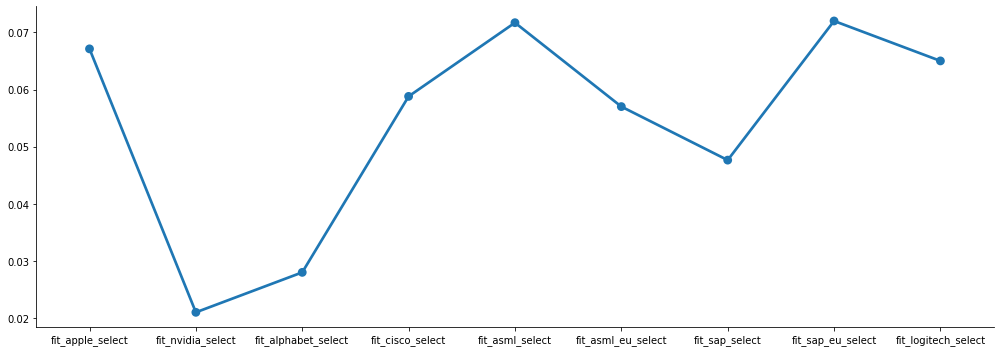

In [80]:
sns.catplot(data = modelle_adjusted_r2.transpose(), kind = "point", linestyles = "-" ,aspect = 2.8)
plt.savefig('Plots/adj. R^2.jpg')

## 5.9 Residuen analysieren

In [81]:
modellenamen_selektiert = ['fit_apple_select','fit_nvidia_select', 'fit_alphabet_select', 'fit_cisco_select', 'fit_asml_select','fit_asml_eu_select','fit_sap_select','fit_sap_eu_select', 'fit_logitech_select']

residuals = fit_apple_select.resid.to_frame().join(fit_nvidia_select.resid.to_frame(),how = 'left', rsuffix = 'nvidia')
residuals = residuals.join(fit_alphabet_select.resid.to_frame(),how = 'left')
residuals = residuals.join(fit_cisco_select.resid.to_frame(),how = 'left', rsuffix = 'cisco')
residuals = residuals.join(fit_asml_select.resid.to_frame(),how = 'left')
residuals = residuals.join(fit_sap_select.resid.to_frame(),how = 'left', rsuffix = 'sap')
residuals = residuals.join(fit_logitech_select.resid.to_frame(),how = 'left')
residuals = residuals.join(fit_asml_eu_select.resid.to_frame(),how = 'left', rsuffix = 'asml_eu')
residuals = residuals.join(fit_sap_eu_select.resid.to_frame(),how = 'left')

residuals.columns = modellenamen_selektiert

/var/folders/r4/xbxvc60d62dfrl7dq7k_kc_40000gn/T/ipykernel_7116/1257007144.py:5: FutureWarning:

Passing 'suffixes' which cause duplicate columns {'0'} in the result is deprecated and will raise a MergeError in a future version.

/var/folders/r4/xbxvc60d62dfrl7dq7k_kc_40000gn/T/ipykernel_7116/1257007144.py:7: FutureWarning:

Passing 'suffixes' which cause duplicate columns {'0'} in the result is deprecated and will raise a MergeError in a future version.

/var/folders/r4/xbxvc60d62dfrl7dq7k_kc_40000gn/T/ipykernel_7116/1257007144.py:9: FutureWarning:

Passing 'suffixes' which cause duplicate columns {'0'} in the result is deprecated and will raise a MergeError in a future version.



### 5.9.1 Normalverteilung

In [82]:
#Mathematisch
jarque_bera_res(residuals)

Der p-Value von fit_nvidia_select ist 0.029095. Somit sind die Residuen nicht normalverteilt.
Der p-Value von fit_asml_eu_select ist 0.000000. Somit sind die Residuen nicht normalverteilt.
Der p-Value von fit_logitech_select ist 0.000000. Somit sind die Residuen nicht normalverteilt.

Die restliche Residuen sind Normalverteilt.


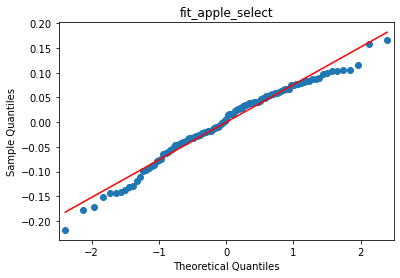

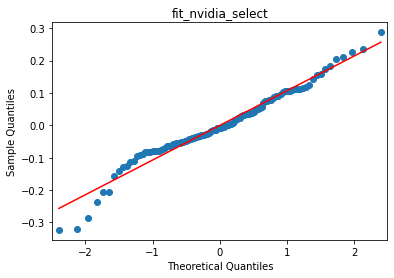

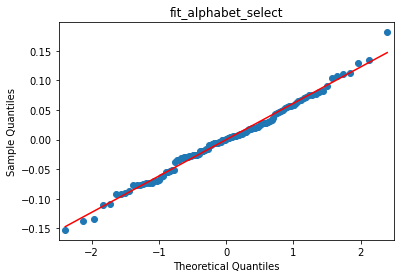

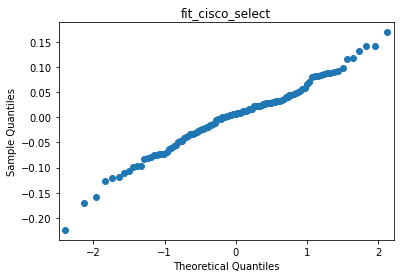

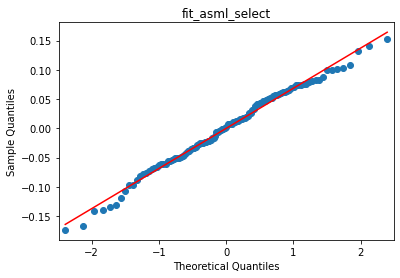

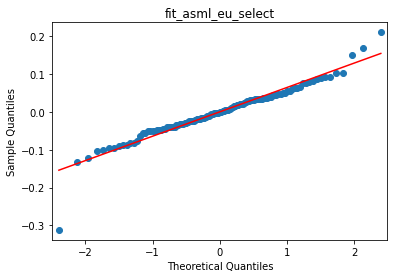

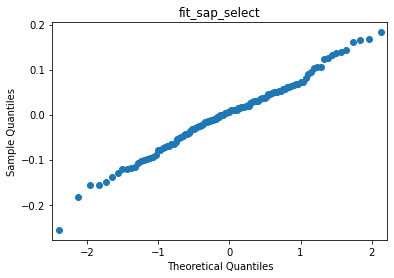

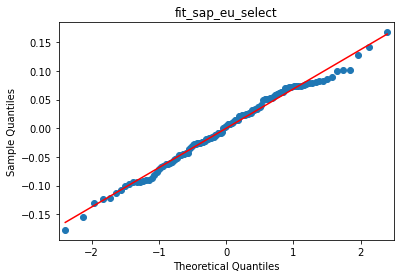

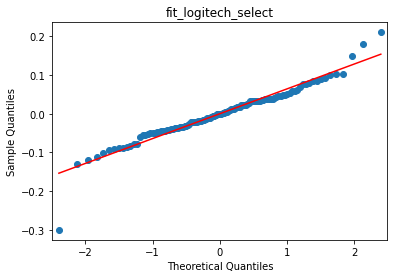

In [83]:
#Optisch (QQ Plot)
import statsmodels.api as smi
import pylab
import matplotlib.pyplot as plt

for i in range(0,len(residuals.columns)):
    x = residuals.iloc[: , i]
    smi.qqplot(x, line = "r")
    plt.title(x.name)
    plt.savefig('Plots/QQ-Plot '+x.name+'.jpg')
    pylab.show()

In [84]:
residuals = residuals.drop(['fit_nvidia_select','fit_asml_eu_select' ,'fit_logitech_select'], 1)

/var/folders/r4/xbxvc60d62dfrl7dq7k_kc_40000gn/T/ipykernel_7116/3328404340.py:1: FutureWarning:

In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.



### 5.9.2 Heteroskedastizität

In [85]:
#Mathematisch
from statsmodels.compat import lzip
import statsmodels.stats.api as sms

breusch_apple = sms.het_breuschpagan(fit_apple_select.resid, fit_apple_select.model.exog)[1]
breusch_alphabet = sms.het_breuschpagan(fit_alphabet_select.resid, fit_alphabet_select.model.exog)[1]
breusch_cisco = sms.het_breuschpagan(fit_cisco_select.resid, fit_cisco_select.model.exog)[1]
breusch_asml = sms.het_breuschpagan(fit_asml_select.resid, fit_asml_select.model.exog)[1]
breusch_sap = sms.het_breuschpagan(fit_sap_select.resid, fit_sap_select.model.exog)[1]
breusch_sap_eu = sms.het_breuschpagan(fit_sap_eu_select.resid, fit_sap_eu_select.model.exog)[1]


breusch = pd.DataFrame([breusch_apple,breusch_alphabet,breusch_cisco,breusch_asml,breusch_sap_eu,breusch_sap], index = residuals.columns)

for i in range(0,len(residuals.columns)):
    if breusch.iloc[i,0] <= 0.05:
        print("Der p-Value von " + str(breusch.index[i]) + " ist %f" % breusch.iloc[i,0] + ". Somit herrscht Heteroskedastizität.")
        
print("")
print("Der Rest ist gut.")

Der p-Value von fit_sap_select ist 0.000002. Somit herrscht Heteroskedastizität.
Der p-Value von fit_sap_eu_select ist 0.000030. Somit herrscht Heteroskedastizität.

Der Rest ist gut.


FileNotFoundError: [Errno 2] No such file or directory: 'Plots/Bilder/Residuals fit_apple_select.jpg'

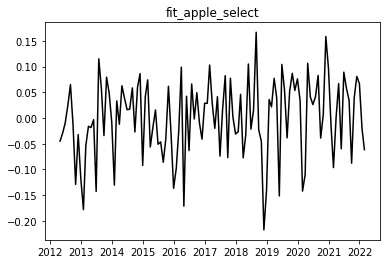

In [86]:
#Optisch
import pandas as pd
import matplotlib.pylab as plt
%matplotlib inline

for i in range(0,len(residuals.columns)):
    x = residuals.iloc[:,i]
    x = np.reshape(x, len(x))

    plt.plot(x, color = 'black',label = 'Residuals')
    plt.title(residuals.columns[i])
    plt.savefig('Plots/Bilder/Residuals '+residuals.columns[i]+'.jpg')
    plt.show()

In [ ]:
residuals = residuals.drop(['fit_sap_select','fit_sap_eu_select'], 1)

### 5.9.3 Autokorrelation

In [ ]:
from statsmodels.stats.stattools import durbin_watson

for i in range(0,len(residuals.columns)):
    durbin = durbin_watson(residuals.iloc[:,i].dropna())
    if durbin > 1.5 and durbin < 2.5:
        print("Der Teststatistik von " + str(residuals.columns[i]) + " ist %f" % durbin + ". Somit herrscht keine Autokorrelation.")

### 5.9.4 MSE

In [ ]:
y_true = assetdata_returns.iloc[:,[0,2,3,4]]

In [ ]:
y_hat_apple = fit_apple_select.predict()
y_hat_apple = pd.DataFrame(y_hat_apple)

y_hat_alphabet = fit_alphabet_select.predict()
y_hat_alphabet = pd.DataFrame(y_hat_alphabet)

y_hat_cisco = fit_cisco_select.predict()
y_hat_cisco = pd.DataFrame(y_hat_cisco)

y_hat_asml = fit_asml_select.predict()
y_hat_asml = pd.DataFrame(y_hat_asml)

y_hat = y_hat_apple.join(y_hat_alphabet, how = 'left', rsuffix = '1').join(y_hat_cisco, how = 'left').join(y_hat_asml, how = 'left', rsuffix = '1')
y_hat.index = y_true.index

y_hat.columns = ['Apple Inc Predict', 'Alphabet Inc Predict', 'Cisco Systems Inc Predict', 'ASML Holding NV Predict']

In [ ]:
#Optiscch
import pandas as pd
import matplotlib.pylab as plt
%matplotlib inline

for i in range(0,len(y_true.columns)):
    x = y_true.iloc[:,i]
    x = np.reshape(x, len(x))
    y = y_hat.iloc[:,i]
    y = np.reshape(y, len(y))

    plt.plot(x, color = 'black',label = y_true.columns[i])
    plt.plot(y, color = 'red', label = y_hat.columns[i])
    plt.legend(loc = 'best')
    plt.savefig('Plots/MSE '+y_true.columns[i]+'.jpg')
    plt.show()

In [ ]:
#Mathematisch
modellenamen_selektiert = ['fit_apple_select', 'fit_alphabet_select', 'fit_cisco_select', 'fit_asml_select']
    
for i in range(0,len(modellenamen_selektiert)):    
    exec(f'mse = {modellenamen_selektiert[i]}.mse_total')
    print('Das ' + str(y_true.columns[i])+ ' Modell hat einen MSE von ' + str(mse) +'.')

## 5.10 Rollingregreession machen (selektiertes Modell)

### 5.10.1 Daten anpassen

In [ ]:
y_werte_neu = y_werte.drop(['NVIDIA Corp','ASML Holding NV EU' ,'SAP SE', 'SAP SE EU', 'Logitech International SA'], 1)

In [ ]:
x_werte_neu = x_werte.drop(['EUPPI=ECI','DEGDP=ECI' ,'EUGDP=ECI', 'Logitech International SA Lag'], 1)

In [ ]:
asset = {'Apple Inc': [0,1,1], 'Alphabet Inc': [1,2,1], 'Cisco Systems Inc': [2,5,3], 'ASML Holding NV': [5,6,0]}
anz_x_werte_neu = pd.DataFrame(data=asset, index = ['Index von', 'Index bis', 'Anzahl'])

### 5.10.2 manuelle Methode

In [ ]:
import statsmodels.api as sm

modellenamen_selektiert_rolling = ['fit_apple_select_rolling', 'fit_alphabet_select_rolling', 'fit_cisco_select_rolling', 'fit_asml_select_rolling']
    
for i in range(0,len(modellenamen_selektiert_rolling)):
    y = y_werte_neu.iloc[:,i]
    
    von = anz_x_werte_neu.iloc[0,i]
    bis = anz_x_werte_neu.iloc[1,i]
    
    x = x_werte_neu.iloc[1:,von:bis]
    
    x = sm.add_constant(x)
    
    exec(f'{modellenamen_selektiert_rolling[i]} = rolling_regression(y.astype(float), x.astype(float), 30)')
    exec(f'{modellenamen_selektiert_rolling[i]} = pd.DataFrame.from_dict(dict(zip({modellenamen_selektiert_rolling[i]}.index, {modellenamen_selektiert_rolling[i]}.values))).T')

In [ ]:
fit_apple_select_rolling.columns=["Beta_1","Beta_2"]
fit_alphabet_select_rolling.columns=["Beta_1","Beta_2"]
fit_cisco_select_rolling.columns=["Beta_1","Beta_2","Beta_3","Beta_4"]
fit_asml_select_rolling.columns = ["Beta_1","Beta_2"]

In [ ]:
import chart_studio
import cufflinks as cf

cf.set_config_file(offline = True)

fit_apple_select_rolling.normalize().iplot()
fit_alphabet_select_rolling.normalize().iplot()
fit_cisco_select_rolling.normalize().iplot()
fit_asml_select_rolling.normalize().iplot()

### 5.10.3 package Methode

In [ ]:
import statsmodels.api as sm
from statsmodels.regression.rolling import RollingOLS

modellenamen_selektiert_rolling = ['fit_apple_select_rolling', 'fit_alphabet_select_rolling', 'fit_cisco_select_rolling', 'fit_asml_select_rolling']
    
for i in range(0,len(modellenamen_selektiert_rolling)):
    y = y_werte_neu.iloc[:,i].values
    
    von = anz_x_werte_neu.iloc[0,i]
    bis = anz_x_werte_neu.iloc[1,i]
    
    x = x_werte_neu.iloc[1:,von:bis]
    x = sm.add_constant(x)
        
    rols = RollingOLS(y.astype(float), x.astype(float), window=30)
    rres = rols.fit()
    
    params = rres.params.copy()
    params.index = np.arange(1, params.shape[0] + 1)
    
    exec(f'{modellenamen_selektiert_rolling[i]}_2 = params')
    exec(f'{modellenamen_selektiert_rolling[i]}_plot_2 = rres')

In [ ]:
fig = plt.figure(figsize=(14,6))
fig = fit_apple_select_rolling_plot_2.plot_recursive_coefficient(fig=fig)

In [ ]:
fig = plt.figure(figsize=(14,6))
fig = fit_alphabet_select_rolling_plot_2.plot_recursive_coefficient(fig=fig)

In [ ]:
fig = plt.figure(figsize=(14,6))
fig = fit_cisco_select_rolling_plot_2.plot_recursive_coefficient(fig=fig)

In [ ]:
fig = plt.figure(figsize=(14,6))
fig = fit_asml_select_rolling_plot_2.plot_recursive_coefficient(fig=fig)

### 5.11 Chow Test

In [ ]:
modellenamen_chow = ['Apple Modell', 'Alphabet Modell', 'Cisco Modell', 'ASML Modell']
import scipy

for i in range(0,len(modellenamen_chow)):
    von = anz_x_werte_neu.iloc[0,i]
    bis = anz_x_werte_neu.iloc[1,i]

    y = y_werte_neu.iloc[:,i]    
    x = x_werte_neu.iloc[1:,von:bis]
    x = sm.add_constant(x)
    
    fit_1 = sm.OLS(y.astype(float),x.astype(float), missing = "drop").fit()
    rssd = fit_1.ssr
    
    y_1 = y_werte_neu.iloc[:60,i]
    x_1 = x_werte_neu.iloc[1:61,von:bis]
    x_1 = sm.add_constant(x_1)    
    
    fit_2 = sm.OLS(y_1.astype(float),x_1.astype(float), missing = "drop").fit()
    rssb = fit_2.ssr
    
    y_2 = y_werte_neu.iloc[60:,i]
    x_2 = x_werte_neu.iloc[61:,von:bis]
    x_2 = sm.add_constant(x_2)
    
    fit_3 = sm.OLS(y_2.astype(float),x_2.astype(float), missing = "drop").fit()
    rssnb = fit_3.ssr
    
    j = x.shape[1]
    k = x_1.shape[1]
    n1 = x_1.shape[0]
    n2 = x_2.shape[0]
    
    werte = (j,k,n1,n2)
    
    chow_statistic = ((rssd-(rssb+rssnb))/j)/((rssb+rssnb)/(n1+n2-2*k))
    chow_wert = scipy.stats.f.cdf(chow_statistic, j, (n1+n2-2*k))

    print('Die Werte für das ' + modellenamen_chow[i] + ' sind ' + str(werte) + ' und der Chow Test zeigt einen Wert von ' + str(chow_wert) + ' an.')

# 6 Daten speichern

In [ ]:
#In Excel
import openpyxl
assetdata.to_excel("Daten/assetdata.xlsx")
assetdata_returns.to_excel("Daten/assetdata_returns.xlsx")

macrodata.to_excel("Daten/macrodata.xlsx")
macrodata_returns.to_excel("Daten/macrodata_returns.xlsx")

macrodata_us.to_excel("Daten/macrodata_us.xlsx")
macrodata_nl.to_excel("Daten/macrodata_nl.xlsx")
macrodata_eu.to_excel("Daten/macrodata_eu.xlsx")
macrodata_ch.to_excel("Daten/macrodata_ch.xlsx")
macrodata_de.to_excel("Daten/macrodata_de.xlsx")
macrodata_cn.to_excel("Daten/macrodata_cn.xlsx")
macrodata_jp.to_excel("Daten/macrodata_jp.xlsx")
macrodata_sk.to_excel("Daten/macrodata_sk.xlsx")

residuals.to_excel("Daten/residuals.xlsx")

total.to_excel("Daten/total.xlsx")

In [ ]:
modellenamen = ['fit_apple', 'fit_nvidia', 'fit_alphabet', 'fit_cisco', 'fit_asml', 'fit_sap', 'fit_logitech', 'fit_tencent', 'fit_samsung', 'fit_sony', 'fit_asml_eu', 'fit_sap_eu', 'fit_logitech_eu']

In [ ]:
#In Text
modellenamen = ['fit_apple', 'fit_nvidia', 'fit_alphabet', 'fit_cisco', 'fit_asml', 'fit_sap', 'fit_logitech', 'fit_tencent', 'fit_samsung', 'fit_sony', 'fit_asml_eu', 'fit_sap_eu', 'fit_logitech_eu']

with open('Resultate/summary_erste_modelle.txt', 'w') as output:
    for i in range(0,len(modellenamen)):
        exec(f'output.write({modellenamen[i]}.summary().as_text())')

In [ ]:
#In Text
modellenamen_selektiert = ['fit_apple_select','fit_nvidia_select', 'fit_alphabet_select', 'fit_cisco_select', 'fit_asml_select','fit_asml_eu_select','fit_sap_select','fit_sap_eu_select', 'fit_logitech_select']

with open('Resultate/summary_selekt_modelle.txt', 'w') as output:
    for i in range(0,len(modellenamen_selektiert)):
        exec(f'output.write({modellenamen_selektiert[i]}.summary().as_text())')

In [ ]:
#In SQL
import pandas as pd
import sqlite3
conn = sqlite3.connect('Daten/AQM.db')

c = conn.cursor()
c.execute('DROP TABLE IF EXISTS assetdata')
assetdata.to_sql('assetdata', con=conn, index = False)

c.execute('DROP TABLE IF EXISTS assetdata_returns')
assetdata_returns.to_sql('assetdata_returns', con=conn, index = False)

c.execute('DROP TABLE IF EXISTS macrodata')
macrodata.to_sql('macrodata', con=conn, index = False)

c.execute('DROP TABLE IF EXISTS macrodata_returns')
macrodata_returns.to_sql('macrodata_returns', con=conn, index = False)

# 7 Sonst

In [ ]:
acf_plot(assetdata,12)